In [13]:
import matplotlib.pyplot as plt
import os
# set working directory for all future cells
os.chdir("/home/yamin/Project/Proj23")
# and check with bash command pwd - note the exclamation mark at the beginning
!pwd
# or in python
os.getcwd()



/home/yamin/Project/Proj23


'/home/yamin/Project/Proj23'

In [2]:
%%bash
cat > "in.partitions" << EOF
    variable p_id world   0 # 1 2 3 4 5
EOF

cat > "in.temp" << EOF
    variable temperature equal \${tmp}
    variable tempDamp equal 0.1 # approx 0.1 ps
EOF

cat > "in.pressure" << EOF
    variable pressure equal 1.
    variable pressureDamp equal 10.0
EOF

cat > "in.seed" << EOF
    variable seed world 74581 # 93734 12832 21934 57383 49172
EOF

cat > "in.box" << EOF
    variable        side equal 22.0
    variable        numAtoms equal 250
    variable        mass equal 22.98977
    region          box block 0 \${side} 0 \${side} 0 \${side}
    create_box      1 box
    create_atoms    1 random \${numAtoms} \${seed} box
    mass            1 \${mass}
    change_box      all triclinic
EOF

cat > "in.na" << EOF
    ### Argon Potential Parameters ###
    pair_style  eam/fs
    pair_coeff  * * Na_MendelevM_2014.eam.fs Na
EOF


cat > "in.setup" << EOF
    variable        out_freq equal 500
    variable        out_freq2 equal 25000
    neigh_modify    delay 10 every 1
    include         in.na
    timestep        0.002 # According to Frenkel and Smit is 0.001
    thermo          \${out_freq}
    thermo_style    custom step temp pe ke press density vol enthalpy atoms lx ly lz xy xz yz pxx pyy pzz pxy pxz pyz
    restart         \${out_freq2} restart/metad/restart.\${temperature}
EOF

cat > "in.dump" << EOF
    dump         myDump all atom \${out_freq2} dump/metad/dump\${temperature}.lammpstrj
    dump_modify  myDump append yes
EOF

In [3]:
%%bash
# create PLUMED input file
cat > "plumed.dat" << EOF
RESTART

LOAD FILE=../PRL-2017-PairEntropy/PairEntropy.cpp

PAIRENTROPY ...
 LABEL=s2
 ATOMS=1-250
 MAXR=0.7
 SIGMA=0.0125
... PAIRENTROPY

ENERGY LABEL=ene

VOLUME LABEL=vol

COMBINE ...
 ARG=ene,vol
 POWERS=1,1
 COEFFICIENTS=1.,0.060221409
 PERIODIC=NO
 LABEL=enthalpy
... COMBINE

COMBINE ...
 ARG=enthalpy
 POWERS=1
 COEFFICIENTS=0.004
 PERIODIC=NO
 LABEL=enthalpyPerAtom
... COMBINE

METAD ...
 LABEL=metad
 ARG=enthalpyPerAtom,s2
 SIGMA=0.2,0.1
 HEIGHT=2.5
 BIASFACTOR=30
 TEMP=350.0
 PACE=500
 GRID_MIN=-110,-8
 GRID_MAX=-90,-1
 GRID_BIN=500,500
 CALC_RCT
... METAD

PRINT STRIDE=500  ARG=* FILE=colvars/COLVAR

EOF

In [15]:
%%bash
cat > "restart.lmp" << EOF
echo both

include in.partitions
log log.lammps.\${p_id} append

include in.temp
include in.pressure
include in.seed
units metal
atom_style full
box tilt large
read_restart restart/metad/restart.\${temperature}.17550000
include in.setup

# NVT
variable kenergy equal ke
variable penergy equal pe
variable pres equal press
variable tempera equal temp
variable dense equal density
variable entha equal enthalpy 

fix myat1 all ave/time 100 5 1000 v_kenergy v_penergy v_pres v_tempera v_dense v_entha file data/no_metad/energy\${temperature}.dat

timer           timeout 23:50:00 every 5000

include         in.dump

fix             1 all plumed plumedfile plumed.dat outfile plumed\${f}.out
fix             2 all nph &
                x \${pressure} \${pressure} \${pressureDamp} &
                y \${pressure} \${pressure} \${pressureDamp} &
                z \${pressure} \${pressure} \${pressureDamp} &
                xy 0.0 0.0 \${pressureDamp} &
                yz 0.0 0.0 \${pressureDamp} &
                xz 0.0 0.0 \${pressureDamp} &
                couple xyz
fix             3 all temp/csvr \${temperature} \${temperature} \${tempDamp} \${seed}
fix             4 all momentum 10000 linear 1 1 1 angular

run           10000000 # 20 ns

EOF

In [16]:
%%bash
lmp -v tmp 350 -v f metad -in restart.lmp

LAMMPS (23 Jun 2022 - Update 4)


../PRL-2017-PairEntropy/PairEntropy.cpp: In member function ‘virtual void PLMD::colvar::PairEntropy::calculate()’:
../PRL-2017-PairEntropy/PairEntropy.cpp:264:21: warning: comparison of integer expressions of different signedness: ‘int’ and ‘unsigned int’ [-Wsign-compare]
  264 |          if (minBin > (nhist-1)) minBin=nhist-1;
      |              ~~~~~~~^~~~~~~~~~~
../PRL-2017-PairEntropy/PairEntropy.cpp:266:21: warning: comparison of integer expressions of different signedness: ‘int’ and ‘unsigned int’ [-Wsign-compare]
  266 |          if (maxBin > (nhist-1)) maxBin=nhist-1;
      |              ~~~~~~~^~~~~~~~~~~


OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task

include in.partitions
    variable p_id world   0 # 1 2 3 4 5
log log.lammps.${p_id} append
log log.lammps.0 append

include in.temp
    variable temperature equal ${tmp}
    variable temperature equal 350
    variable tempDamp equal 0.1 # approx 0.1 ps
include in.pressure
    variable pressure equal 1.
    variable pressureDamp equal 10.0
include in.seed
    variable seed world 74581 # 93734 12832 21934 57383 49172
units metal
atom_style full
box tilt large
read_restart restart/metad/restart.${temperature}.17550000
read_restart restart/metad/restart.350.17550000
Reading restart file ...
  restart file = 23 Jun 2022, LAMMPS = 23 Jun 2022
  restoring atom style full from restart
  triclinic box = (0.02355854 0.02355854 0.02355854) to (21.976441 21.976441 21.976441) with tilt (-4.6770342 5.7462949 -2.8036839)
  1 by 1 by 1 MPI processor grid
  pair style eam/fs store

  17550000   329.03725     -255.73373      10.590319     -1177.1135      0.90208822     10579.732     -252.91631            250   21.952883      21.952883      21.952883     -4.6770342      5.7462949     -2.8036839     -1256.9067     -814.36092     -1460.073      -324.38357     -233.82033     -156.58436    
  17550500   394.69256     -254.39638      12.703486     -124.56574      0.89445816     10669.981     -242.52246            250   22.015128      22.015128      22.015128     -4.8109424      5.8327523     -2.9184915      826.07983     -597.76719     -602.00987      24.863762     -910.8822      -163.73907    
  17551000   348.78374     -252.82615      11.225875      217.10778      0.88785755     10749.305     -240.14366            250   22.069549      22.069549      22.069549     -4.9767093      5.883752      -3.0510766      520.73169      486.68597     -356.09433     -633.77986     -403.71164     -85.799679    
  17551500   362.39767     -252.30742      11.66405      -449.98562      

  17563500   323.3413      -253.84154      10.406991     -141.50569      0.91790857     10397.388     -244.35286            250   21.82603       21.82603       21.82603      -11.521186      7.2262864     -3.7550289      154.67089     -61.2663       -517.92166     -22.596241      200.81429     -910.7937     
  17564000   315.47648     -253.81879      10.153855      125.94564      0.92534102     10313.875     -242.85417            250   21.767437      21.767437      21.767437     -11.953605      7.3458161     -3.8931257      352.77848     -148.0389       173.09734      664.50703     -42.346405      74.828708    
  17564500   351.00122     -253.96979      11.297247      802.78931      0.92820279     10282.076     -237.52058            250   21.745043      21.745043      21.745043     -12.330353      7.4774177     -4.0067156      1740.3876      31.14523       636.83512      480.21758      357.04027      56.346295    
  17565000   382.55513     -253.85845      12.312834      399.19171      

  17577000   381.15767     -255.52451      12.267856     -593.753        0.91989231     10374.967     -247.10153            250   21.81033       21.81033       21.81033       5.3114572      7.440044      -2.628754      -161.63631     -822.09499     -797.52771      231.7657       137.60025      5.4154971    
  17577500   361.7814      -254.81721      11.644215     -90.80948       0.92105572     10361.862     -243.76029            250   21.801143      21.801143      21.801143      5.2066349      7.1713435     -2.3598968      116.82027      486.94506     -876.19377      211.00664      509.39707      8.5550571    
  17578000   347.8608      -256.69317      11.19617      -184.40022      0.92820905     10282.007     -246.68039            250   21.744994      21.744994      21.744994      5.1085097      6.9162537     -2.0723531     -55.57397      -16.675469     -480.95122      514.02497     -394.90391      663.04933    
  17578500   338.21193     -255.63483      10.885614      763.01071      

  17590500   356.59924     -254.9198       11.477423      996.82732      0.92929888     10269.949     -237.05272            250   21.736491      21.736491      21.736491      2.9150482      3.5251395      2.5094346      1544.4332      853.61172      592.43706     -439.6467       386.7175      -473.30073    
  17591000   321.19792     -254.02576      10.338004     -390.15426      0.90335631     10564.881     -246.26046            250   21.942606      21.942606      21.942606      2.9821872      3.5533887      2.6741197     -817.20277     -141.51324     -211.74677      692.38333     -63.995365      1177.2749    
  17591500   372.13956     -252.75247      11.977601     -30.730861      0.87720807     10879.804     -240.98356            250   22.1585        22.1585        22.1585        3.1024131      3.5921612      2.8787922      652.96264     -641.6588      -103.49642     -276.73941      82.862596      26.432455    
  17592000   332.32043     -249.31284      10.695991      47.220124      

  17604000   344.25064     -254.62489      11.079974      668.11304      0.93271743     10232.308     -239.27801            250   21.709902      21.709902      21.709902      4.9125173      2.0090004      7.1910367      988.18261      1206.2028     -190.04626      458.83569     -105.31414     -155.11599    
  17604500   343.69648     -255.7759       11.062138      629.92772      0.93417479     10216.345     -240.697              250   21.698607      21.698607      21.698607      4.8888967      1.8133972      7.4534103      617.12404      1066.0284      206.63067     -242.87012     -136.59524     -286.30089    
  17605000   355.94361     -257.33574      11.456321     -320.13692      0.92757516     10289.034     -247.93531            250   21.749947      21.749947      21.749947      4.8549437      1.642219       7.7254406     -924.22539      390.26841     -426.45377      211.15489     -3.5927035     -5.7264707    
  17605500   362.71071     -257.51862      11.674126     -611.14331      

  17617500   330.14892     -251.30543      10.626099     -582.9889       0.88083646     10834.987     -244.62189            250   22.128033      22.128033      22.128033      2.2655215     -4.1788041      10.606141     -1069.3514     -402.92326     -276.69201      216.65273      229.57764     -218.39352    
  17618000   354.66146     -250.35324      11.415054     -214.77437      0.8686925      10986.456     -240.41094            250   22.230669      22.230669      22.230669      2.1974762     -4.4712836      10.72564       108.73484     -421.04367     -332.01429     -252.71854      551.30909      104.44957    
  17618500   356.38211     -249.0554       11.470435     -147.72303      0.85951737     11103.734     -238.60874            250   22.309492      22.309492      22.309492      2.1281255     -4.7291397      10.858408     -397.20149      405.21038     -451.17797      212.73083      648.59993     -52.585307    
  17619000   319.04506     -248.33309      10.268713     -432.7368       

  17631000   351.72267     -256.35021      11.320467      1521.083       0.9517359      10027.837     -235.50946            250   21.564319      21.564319      21.564319      2.6675663     -4.9944056      11.73781       794.36731      1844.1734      1924.7084      259.5772       256.52513      482.04442    
  17631500   337.45973     -257.1246       10.861403      567.45002      0.93194692     10240.768     -242.63618            250   21.715884      21.715884      21.715884      2.8534773     -4.8908148      11.898714      747.48114      768.27982      186.58909      267.58631      879.55919      204.37006    
  17632000   353.99207     -254.72304      11.393509     -380.05093      0.89795895     10628.383     -245.85068            250   21.986482      21.986482      21.986482      3.1286524     -4.7417567      12.170444     -686.46657     -633.48305      179.79684      503.11263     -369.98699      47.328805    
  17632500   362.81773     -253.73205      11.67757      -295.79797      

  17644500   345.63455     -250.92239      11.124516      115.26204      0.86153317     11077.753     -239.00093            250   22.292079      22.292079      22.292079      4.1049757     -6.4755628      8.8032842     -229.4407       245.24267      329.98416     -395.84418      505.93398      108.40206    
  17645000   340.04946     -249.69672      10.944756     -103.80615      0.84331632     11317.049     -239.4852             250   22.45145       22.45145       22.45145       4.1914187     -6.7730148      8.8887776     -994.40387      880.98272     -197.99732      70.000035      528.53327     -172.9906     
  17645500   362.94618     -247.04284      11.681704     -364.77701      0.82408921     11581.091     -237.99787            250   22.624717      22.624717      22.624717      4.2543923     -7.0621862      8.9741886     -220.2294      -64.442188     -809.65944     -347.24322     -152.76302     -285.26446    
  17646000   324.514       -246.76146      10.444735     -776.12764      

  17658000   332.4178      -256.8827       10.699125      805.12448      0.94212728     10130.109     -241.093              250   21.637382      21.637382      21.637382      2.3303823     -10.324035      5.4016001      967.62577      1466.8644     -19.116682     -509.00475      356.837       -250.65191    
  17658500   365.10621     -255.75279      11.751227      1064.026       0.94516082     10097.596     -237.29562            250   21.614208      21.614208      21.614208      2.1494518     -10.320793      5.2229292      1903.5557      1090.9894      197.53284      97.521952      632.25548      189.44967    
  17659000   342.47636     -257.05306      11.022868     -786.59022      0.92761628     10288.578     -251.08138            250   21.749625      21.749625      21.749625      2.0244525     -10.373465      5.1205789     -969.04578     -964.48251     -426.24236      615.04931     -935.34161     -141.99666    
  17659500   309.49389     -256.57646      9.9613009     -842.48935      

  17671500   382.16116     -252.06184      12.300154      706.1786       0.92043206     10368.883     -235.19147            250   21.806066      21.806066      21.806066      4.0200768     -7.6678605     -0.57255408     1022.7079      326.15854      769.66933      282.13297      447.66714      57.754726    
  17672000   337.13708     -252.17169      10.851019      603.36449      0.91871567     10388.254     -237.40855            250   21.819637      21.819637      21.819637      4.1072791     -7.5813389     -0.8960091      267.66932      770.97214      771.45202     -858.40275     -313.62972     -40.043906    
  17672500   319.1251      -251.26428      10.271289      141.75238      0.90482779     10547.7       -240.05979            250   21.930705      21.930705      21.930705      4.1726524     -7.5697933     -1.2107276      549.48542      549.5578      -673.78607      76.549871     -391.17925     -14.128079    
  17673000   353.0664      -251.76874      11.363716     -5.2931553      

  17685000   343.58093     -253.44554      11.058419      664.84509      0.93018148     10260.204     -238.12951            250   21.729613      21.729613      21.729613      7.8540122     -4.1306836     -5.2816958      247.64651      707.67406      1039.2147      107.4193      -887.18581      330.8351     
  17685500   353.67487     -253.7148       11.3833        586.57685      0.92759103     10288.858     -238.56462            250   21.749823      21.749823      21.749823      7.9779619     -3.9955584     -5.3265649      1028.5532     -225.73989      956.91724     -69.45755       620.03383      61.392579    
  17686000   345.81378     -251.83256      11.130285      155.03925      0.9134596      10448.029     -239.69124            250   21.861407      21.861407      21.861407      8.0932446     -3.8727434     -5.3558518      71.086641     -324.08476      718.11587      226.81305     -118.98369     -108.13461    
  17686500   337.9739      -251.53274      10.877952     -1476.2982      

  17698500   338.79536     -253.25565      10.904392      904.01514      0.91771239     10399.611     -236.48336            250   21.827586      21.827586      21.827586      12.486752     -3.0023102     -4.9901484      1251.3349      314.04908      1146.6615     -34.953301     -206.74888      461.20688    
  17699000   383.16179     -251.92451      12.33236       411.72327      0.89922365     10613.435     -236.86474            250   21.976169      21.976169      21.976169      12.930746     -3.0116956     -4.9954583      822.19244     -34.216644      447.19401     -327.91756      217.67208     -531.11962    
  17699500   364.01519     -251.70225      11.716111     -686.23604      0.87554807     10900.432     -244.65496            250   22.172495      22.172495      22.172495     -8.7333803     -3.0182834     -5.0311338     -952.79576     -465.73235     -640.18002      277.00814      330.3592      -95.245698    
  17700000   338.67773     -249.90879      10.900606     -322.08541      

  17712000   351.53538     -255.65869      11.314439     -1.9795153      0.91884564     10386.785     -244.35708            250   21.818608      21.818608      21.818608     -8.4080226     -1.0764408     -7.9517198     -148.7304       276.63682     -133.84497      947.803        611.12945      31.058143    
  17712500   326.21849     -254.55223      10.499595     -405.05486      0.90635939     10529.876     -246.71475            250   21.918345      21.918345      21.918345     -8.4868827     -0.97645118    -8.107076      -187.54932     -283.11992     -744.49534      311.53762      524.97812      196.6697     
  17713000   334.0411      -253.86574      10.751372     -463.90912      0.90105468     10591.868     -246.18123            250   21.961273      21.961273      21.961273     -8.4967263     -0.88278991    -8.1889455     -97.589886     -885.06497     -409.07251      278.54887      117.32487      28.629842    
  17713500   336.20962     -252.90763      10.821168     -99.704917      

  17725500   368.15855     -255.1492       11.849469      269.71538      0.9196178      10378.064     -241.55265            250   21.8125        21.8125        21.8125       -5.9515086      5.2239038     -8.6339885      1109.0912      471.71615     -771.6612      -171.01534     -269.06689     -187.63172    
  17726000   348.55733     -251.236        11.218588      1130.9949      0.91699291     10407.771     -232.67045            250   21.833293      21.833293      21.833293     -5.962028       5.3871732     -8.7683872      763.63406      1619.3602      1009.9903      278.38548      177.22691     -723.27278    
  17726500   379.00753     -251.96221      12.198652      377.49831      0.89890944     10617.145     -237.26199            250   21.97873       21.97873       21.97873      -6.0295742      5.6050913     -9.0232311      400.32111      623.03041      109.1434       861.68576     -94.875804      433.51785    
  17727000   340.32404     -252.6782       10.953593     -814.09855      

  17739000   387.05138     -259.68046      12.457549      417.65704      0.94985968     10047.644     -244.60368            250   21.578508      21.578508      21.578508     -5.2658085      1.4731763      8.0041891      213.53061      629.80714      409.63336      535.68953      132.45678      279.42419    
  17739500   357.74731     -257.96851      11.514375     -505.8509       0.93578668     10198.747     -249.67416            250   21.686141      21.686141      21.686141     -5.2487971      1.6519335      7.8422183     -7.3393105      218.0808      -1728.2942      1049.2333      11.999481      625.135      
  17740000   313.73533     -256.75797      10.097815     -558.16187      0.92448025     10323.479     -250.25662            250   21.774191      21.774191      21.774191     -5.0909387      1.8972574      7.7108073     -247.08957     -533.64439     -893.75164      556.30576     -117.06219      184.45399    
  17740500   324.46138     -252.6554       10.443041      785.62451      

  17752500   310.28852     -258.97553      9.9868769     -1132.789       0.93612252     10195.088     -256.1969             250   21.683547      21.683547      21.683547     -2.0422187      7.8410601      4.9606512     -730.79719     -1338.0045     -1329.5654      56.194435      410.68996     -7.3182927    
  17753000   343.48238     -258.66561      11.055247     -1473.2123      0.92844252     10279.422     -257.06236            250   21.743172      21.743172      21.743172     -2.0028121      8.1211683      4.8979843     -1538.3025     -1277.157      -1604.1773     -635.04446     -554.72654      306.63761    
  17753500   346.65403     -257.26638      11.157329      437.26679      0.94410149     10108.926     -243.35012            250   21.622289      21.622289      21.622289     -1.9468869      8.3151556      4.8299589      476.93199      1148.6038     -313.73546     -523.39288     -109.03712     -617.99979    
  17754000   367.35069     -255.86097      11.823467      1557.759       

  17766000   339.99215     -255.23696      10.942911      107.84541      0.91103384     10475.848     -243.5889             250   21.880793      21.880793      21.880793     -1.1641898      9.7758002      6.0197198      60.308653      67.217677      196.00989      607.23631      1478.7131     -485.17287    
  17766500   379.34835     -255.18945      12.209621     -97.213662      0.90035069     10600.15      -243.623              250   21.966996      21.966996      21.966996     -1.1120756      9.8686898      6.0643679      13.752158     -310.52003      5.1268899     -331.18416      168.17925      777.0546     
  17767000   348.45907     -253.50348      11.215425     -271.85011      0.89233752     10695.339     -244.10279            250   22.032554      22.032554      22.032554     -1.0732725      9.9590269      6.1606922     -848.3521      -199.14103      231.9428       193.76285      247.64618      458.14605    
  17767500   349.06071     -250.96554      11.23479       180.24457      

  17779500   319.50523     -256.67408      10.283524     -504.81252      0.92638622     10302.239     -249.63657            250   21.759247      21.759247      21.759247     -2.6018166      11.753823      6.9165829      278.06186     -760.3621      -1032.1373     -400.95875      283.92516     -42.539379    
  17780000   376.80738     -256.54737      12.127838      302.56216      0.93282743     10231.101     -242.48744            250   21.709049      21.709049      21.709049     -2.5842912      11.663439      6.8124614     -26.70347       232.30967      702.08029      21.812038      39.431091     -602.17076    
  17780500   361.39874     -257.70236      11.631899     -230.32807      0.93414976     10216.619     -247.5392             250   21.698801      21.698801      21.698801     -2.565146       11.578687      6.6525692     -17.005857     -533.63103     -140.34732     -534.9345      -421.54575      531.81958    
  17781000   349.37143     -257.22259      11.24479      -154.27085      

  17793000   320.24058     -265.04167      10.307192     -803.67859      0.94877057     10059.178     -259.78033            250   21.586762      21.586762      21.586762     -1.5830181      11.406793      8.003171      -2194.1102     -855.09718      638.17159      685.7061      -275.53168     -561.67852    
  17793500   328.50636     -263.57466      10.573232     -101.73044      0.94974865     10048.819     -253.63948            250   21.579349      21.579349      21.579349     -1.5405548      11.364139      7.9037542     -2016.182      -295.86921      2006.8599     -216.23886     -359.57239      80.130092    
  17794000   347.72295     -264.83755      11.191733      289.61643      0.9515875      10029.4       -251.83286            250   21.56544       21.56544       21.56544      -1.4808026      11.259584      7.7900477     -1069.328      -307.55666      2245.734      -546.24016     -100.66121     -73.776004    
  17794500   344.40994     -264.42963      11.085101     -13.98272       

  17806500   337.47716     -264.81156      10.861964      876.07458      0.95931795     9948.5806     -248.50969            250   21.507357      21.507357      21.507357     -1.318935       10.519853      7.8195384      321.4844       287.42586      2019.3135     -742.26429      9.8535746     -6.9623477    
  17807000   323.70468     -262.65917      10.418686      335.11588      0.94960738     10050.314     -250.13833            250   21.580419      21.580419      21.580419     -1.3648773      10.423398      7.8479364     -252.00346     -480.80297      1738.1541      161.51382      146.33363     -343.4596     
  17807500   345.54225     -261.4408       11.121545     -336.50247      0.94053692     10147.238     -252.45046            250   21.64957       21.64957       21.64957      -1.4619044      10.324522      7.8637443     -1361.959      -584.35102      936.80263     -477.16211      145.61575      331.68647    
  17808000   342.07135     -263.9048       11.009832     -644.57583      

  17820000   323.16934     -261.40459      10.401456     -38.574749      0.94392153     10110.853     -251.24657            250   21.623663      21.623663      21.623663     -1.582708       9.8280983      8.220226      -421.73398     -581.28384      887.29358     -106.03822      285.30636     -455.13322    
  17820500   366.09027     -263.75424      11.7829        1378.3064      0.96149164     9926.0894     -243.43222            250   21.491137      21.491137      21.491137     -1.8379654      9.7493345      8.2156425      734.29277      142.65359      3257.9729     -96.554591      230.97498     -246.42727    
  17821000   357.65875     -262.21057      11.511524      261.26506      0.94803125     10067.023     -249.05743            250   21.592372      21.592372      21.592372     -2.088179       9.8290262      8.285383      -685.27045     -312.57806      1781.6437     -6.7813499     -29.095691     -758.16187    
  17821500   364.13733     -260.41306      11.720043     -1249.4263      

  17833500   329.26091     -265.11316      10.597518     -772.06551      0.94719386     10075.923     -259.37108            250   21.598733      21.598733      21.598733     -2.1326723      10.437314      8.6931795     -2176.8518     -714.03897      574.69428      1464.4396      77.56412      -990.34921    
  17834000   370.7063      -263.88157      11.93147       152.32389      0.95156245     10029.664     -250.99654            250   21.565629      21.565629      21.565629     -2.099348       10.742599      8.6481328     -878.48024     -386.55566      1722.0076      1064.4933     -92.153186     -427.18009    
  17834500   364.16885     -264.7156       11.721057      648.9514       0.95523094     9991.1462     -248.94769            250   21.537987      21.537987      21.537987     -1.8770451      11.133758      8.4891911     -750.65585      873.67338      1823.8367      555.69124     -335.49002     -446.99601    
  17835000   376.28807     -264.14359      12.111123     -545.83433      

  17847000   370.96873     -263.69349      11.939917     -350.26159      0.94726488     10075.167     -253.95617            250   21.598193      21.598193      21.598193     -1.4244576      11.570621      8.1163299     -2130.6128     -425.37135      1505.1993      75.614159     -509.32412     -232.97836    
  17847500   336.94989     -262.95719      10.844994      87.881876      0.94915276     10055.127     -251.56066            250   21.583864      21.583864      21.583864     -1.1344649      11.616405      8.0493109     -1348.5414     -116.54626      1728.7333     -326.04536     -10.900022     -65.740994    
  17848000   358.45252     -263.78054      11.537073      383.08502      0.9505488      10040.36      -249.84279            250   21.573292      21.573292      21.573292     -0.9026596      11.578161      7.9748258     -1182.0875      343.38582      1987.9567     -786.35691     -179.00422      352.13931    
  17848500   349.68041     -263.62999      11.254735     -285.4328       

  17860500   347.83431     -263.33779      11.195317     -711.85473      0.94395261     10110.52      -256.63463            250   21.623426      21.623426      21.623426     -1.0027208      10.921593      7.6213474     -1812.7548     -1388.2581      1065.4487     -1304.0695      577.56367      832.13993    
  17861000   353.79493     -263.97556      11.387164      487.61383      0.95495395     9994.0442     -249.54676            250   21.540069      21.540069      21.540069     -1.0867683      10.561216      7.7011071     -466.575       -635.32973      2564.7462     -861.34885     -78.750527      386.68856    
  17861500   345.58729     -262.17111      11.122995      1175.8436      0.95552546     9988.0666     -243.71783            250   21.535774      21.535774      21.535774     -1.3148741      10.170778      7.9028253      303.35502      439.37167      2784.8043     -396.35818     -93.633814      275.04733    
  17862000   377.90995     -262.68733      12.163325     -531.15942      

  17874000   345.07371     -264.24121      11.106465     -19.475463      0.95376712     10006.48      -253.25638            250   21.549         21.549         21.549        -1.4507773      9.7927961      7.8411148     -670.65296     -1174.0338      1786.2604     -389.05128      103.40175      154.45037    
  17874500   320.54869     -266.65217      10.317108      2104.2255      0.97079025     9831.0134     -243.42346            250   21.4223        21.4223        21.4223       -1.6307281      9.6070944      7.944402       1614.4967      479.05717      4219.1227      542.79729      432.75458     -42.627216    
  17875000   357.45576     -265.07981      11.504991     -552.86724      0.94949973     10051.453     -257.0433             250   21.581234      21.581234      21.581234     -1.8230985      9.6447931      8.1628434     -842.26489     -2254.453       1438.1162      877.18214      609.46207     -62.502208    
  17875500   341.90447     -261.71714      11.004461     -1533.0847      

  17887500   353.81396     -261.5393       11.387777      155.84399      0.94701436     10077.832     -249.17125            250   21.600097      21.600097      21.600097     -1.8967974      10.215107      7.8698211     -189.29417     -393.68408      1050.5102      198.00484     -135.81538     -522.32218    
  17888000   337.19636     -262.1953       10.852926      727.32352      0.95333264     10011.041     -246.79776            250   21.552273      21.552273      21.552273     -1.8881544      10.407838      7.971615      -488.26258      28.534186      2641.699      -64.328891     -15.869316     -77.324128    
  17888500   329.40826     -262.96892      10.602261      279.81772      0.95137935     10031.595     -250.61466            250   21.567013      21.567013      21.567013     -1.8173087      10.681074      8.0582315     -781.61851     -47.753806      1668.8255     -120.91738     -63.485464     -78.622693    
  17889000   355.20524     -265.2092       11.432556     -349.64633      

  17901000   362.13698     -265.47576      11.65566      -365.17027      0.95412324     10002.746     -256.09994            250   21.546318      21.546318      21.546318     -1.9196942      11.556889      7.8177529     -2017.0933     -873.69779      1795.2803      292.6556      -729.75223     -459.82971    
  17901500   345.00769     -262.13033      11.10434       154.21439      0.94702107     10077.761     -250.05597            250   21.600046      21.600046      21.600046     -1.7813865      11.498647      7.8480079     -1528.3431      511.07741      1479.9089      459.67005     -120.66725     -475.17098    
  17902000   363.0219      -261.22567      11.684142     -375.97688      0.93708588     10184.608     -251.93151            250   21.676114      21.676114      21.676114     -1.5706123      11.409995      7.8380331     -2035.0087      84.292225      822.78588     -38.996995     -576.20776      111.23511    
  17902500   335.03554     -261.57459      10.783379     -689.66484      

  17914500   371.05643     -261.96168      11.942739      497.88529      0.94919494     10054.681     -246.8944             250   21.583544      21.583544      21.583544     -1.6746097      10.328934      7.4040147      204.19449     -353.85317      1643.3146     -460.59406      301.58684      570.24532    
  17915000   340.35743     -261.44962      10.954668      661.39499      0.94986727     10047.564     -246.34721            250   21.578451      21.578451      21.578451     -1.476996       10.155689      7.4217707     -194.76166     -210.54417      2389.4908     -662.428        245.03889      173.7422     
  17915500   359.99186     -262.03264      11.586618      291.84357      0.94555496     10093.387     -248.60746            250   21.611205      21.611205      21.611205     -1.3821783      10.045445      7.5064797     -478.82988     -1100.6886      2455.0492     -260.83019      397.90305      429.83118    
  17916000   317.10832     -261.60637      10.206377     -333.00349      

  17928000   386.75196     -264.50215      12.447912      526.26782      0.95714923     9971.1222     -248.77902            250   21.523588      21.523588      21.523588     -1.7714368      9.2599748      7.0069938      747.64098     -1363.6618      2194.8243     -668.89126      1283.6025      443.60865    
  17928500   352.01298     -263.58313      11.329811      809.66594      0.95743861     9968.1085     -247.2159             250   21.52142       21.52142       21.52142      -1.6556923      9.4112098      7.0835547      661.99293     -434.22141      2201.2263     -805.18796      1103.8332      461.78975    
  17929000   350.9413      -265.7102       11.295318     -788.30055      0.95172037     10028         -259.34885            250   21.564436      21.564436      21.564436     -1.6306427      9.67527        7.25896       -1211.4034     -1766.8069      613.30868     -449.44229      640.69842      231.86136    
  17929500   359.45121     -264.62663      11.569216     -5.4913078      

  17941500   342.14362     -262.89728      11.012158     -927.24597      0.94118398     10140.262     -257.75371            250   21.644608      21.644608      21.644608     -2.0908084      10.743945      7.0843277     -1999.8642     -1908.6862      1126.8125      253.83527      13.946541      364.00912    
  17942000   336.02839     -265.69202      10.815334      1595.2054      0.96543154     9885.5812     -245.03411            250   21.461862      21.461862      21.461862     -2.1434508      10.93787       7.0878112     -81.143618      890.86103      3975.8989      644.21749      102.24347      61.979179    
  17942500   342.03294     -266.33991      11.008596      536.11763      0.96168693     9924.0737     -252.01054            250   21.489682      21.489682      21.489682     -2.1361773      11.177202      7.1630959     -1133.4479      574.1824       2167.6184      830.87639     -331.36402     -259.53394    
  17943000   327.7105      -264.46205      10.547617     -754.93855      

  17955000   311.96126     -262.09228      10.040715      806.37092      0.95605881     9982.4947     -247.0274             250   21.531768      21.531768      21.531768     -1.8931201      11.357324      7.0338285     -1275.1425      902.45314      2791.8022     -203.72179     -672.17114     -19.492092    
  17955500   348.45234     -266.55701      11.215209      828.39659      0.96116167     9929.4971     -250.20781            250   21.493596      21.493596      21.493596     -1.7383314      11.084837      6.9526702     -1312.5382      550.19534      3247.5326     -869.73277      73.676966     -111.2955     
  17956000   353.00451     -263.77924      11.361724      49.916361      0.95249974     10019.795     -252.10534            250   21.558553      21.558553      21.558553     -1.6661335      10.797327      6.9814831     -1939.6815     -472.08907      2561.5196     -378.09142     -181.49023     -81.729617    
  17956500   363.12462     -261.03543      11.687448      230.58766      

  17968500   338.23283     -260.58471      10.886286      334.86399      0.94569019     10091.943     -247.58915            250   21.610174      21.610174      21.610174     -1.5344864      9.8991201      6.7563216      140.56986     -909.09622      1773.1183     -423.63857      398.77043      710.11024    
  17969000   350.95976     -260.8604       11.295912      23.240723      0.94317746     10118.83      -249.41771            250   21.629348      21.629348      21.629348     -1.6621592      9.7099573      6.7160568     -828.57307     -816.56316      1714.8584     -695.77891      215.29542      699.02143    
  17969500   341.5008      -260.06134      10.991468      56.195795      0.9400341      10152.666     -248.71377            250   21.65343       21.65343       21.65343      -1.8451214      9.5553767      6.7546456     -459.80816     -401.71714      1030.1127     -26.021317      127.52001      465.91126    
  17970000   346.22611     -260.25802      11.143556      281.11511      

  17982000   319.16665     -262.94369      10.272626      520.99836      0.95237308     10021.127     -249.41238            250   21.559509      21.559509      21.559509     -1.8464798      9.5307565      6.74121       -506.05314     -70.071513      2139.1197      43.827382      701.78607      326.59566    
  17982500   339.13162     -263.35331      10.915215      993.33249      0.96066876     9934.5918     -246.27875            250   21.497272      21.497272      21.497272     -2.0766517      9.5422851      6.6345535      192.52839     -529.39745      3316.8665     -41.764734      687.19332      420.79042    
  17983000   380.58849     -260.88252      12.249536      1077.4153      0.95138895     10031.493     -241.8871             250   21.56694       21.56694       21.56694      -2.3547735      9.714067       6.6427502      99.966546      698.76469      2433.5148      539.84143      514.07427      434.93356    
  17983500   345.02781     -260.68061      11.104988     -884.10096      

  17995500   350.64609     -263.97201      11.285817      611.6409       0.95684538     9974.2886     -248.87845            250   21.525867      21.525867      21.525867     -1.4486071      10.911786      7.6834025     -1560.9662      656.17301      2739.7159     -558.87866     -28.661444      331.66331    
  17996000   324.20115     -265.26551      10.434666     -510.30367      0.95125518     10032.904     -258.02639            250   21.567951      21.567951      21.567951     -1.8467274      10.969927      7.6809386     -1496.4769     -1189.4256      1154.9915     -112.27708      306.08693     -20.294979    
  17996500   391.16691     -262.36174      12.590011      529.27254      0.94985555     10047.688     -246.45251            250   21.578539      21.578539      21.578539     -2.2447801      10.988546      7.6639967     -760.05058      801.98656      1545.8816      1240.0105     -150.42199     -1017.3847    
  17997000   344.29516     -263.20636      11.081407     -230.16783      

  18009000   338.25314     -264.89174      10.88694       677.60205      0.9592291      9949.5021     -249.7969             250   21.508021      21.508021      21.508021     -1.6206032      10.809923      8.4864333     -541.18106      28.09941       2545.8878      94.078157     -348.30541     -213.42609    
  18009500   365.61983     -261.78308      11.767758     -175.59513      0.94428304     10106.982     -251.12303            250   21.620903      21.620903      21.620903     -1.6983571      10.797818      8.622549      -1353.3811     -372.60756      1199.2033      747.08198     -193.47575     -527.86027    
  18010000   355.63562     -259.88998      11.446409     -651.94182      0.93173005     10243.151     -252.61162            250   21.717568      21.717568      21.717568     -1.697538       10.750956      8.672146      -1308.8611     -1213.3746      566.41024      543.58055     -365.80167     -462.27774    
  18010500   358.81232     -263.02388      11.548653     -1446.2166      

  18022500   338.60921     -262.61141      10.8984        128.60689      0.94954483     10050.976     -250.90622            250   21.580893      21.580893      21.580893     -1.9279498      10.197819      8.2852758     -473.09944     -635.67283      1494.5929      563.45119      246.75238     -583.75961    
  18023000   341.03361     -264.91466      10.976432      1841.01        0.97071207     9831.8052     -242.64081            250   21.422875      21.422875      21.422875     -1.6197549      10.188141      8.2310749      951.08902      708.22926      3863.7116      214.6405      -85.233219     -352.91799    
  18023500   355.24098     -263.77644      11.433706      390.56997      0.95626305     9980.3626     -249.90977            250   21.530235      21.530235      21.530235     -1.2166176      10.357323      8.2311196     -572.60527     -722.90946      2467.2246     -529.99588      320.67701     -94.023706    
  18024000   346.30288     -261.25102      11.146027     -953.92782      

  18036000   333.05674     -261.88677      10.71969      -379.93368      0.94264649     10124.529     -253.56797            250   21.633408      21.633408      21.633408     -0.99744232     11.106146      8.0391636     -1432.8082     -904.46625      1197.4734     -871.23892      29.921853      356.42107    
  18036500   357.72379     -260.42562      11.513618     -289.72218      0.93699072     10185.642     -250.75388            250   21.676848      21.676848      21.676848     -0.80303551     11.210073      8.1998207     -1117.8694     -835.53365      1084.2365     -693.84731     -197.40375     -60.608321    
  18037000   346.56395     -261.20098      11.15443      -239.7262       0.93981958     10154.983     -251.56599            250   21.655077      21.655077      21.655077     -0.6913962      11.226587      8.4121553     -1086.5863     -423.95434      791.36204     -648.91729      496.50734      190.44642    
  18037500   340.85356     -262.32034      10.970636      587.41385      

  18049500   347.27183     -260.54842      11.177213      269.00554      0.94489641     10100.421     -247.67534            250   21.616224      21.616224      21.616224     -1.3575256      10.999765      8.0784693     -364.60324     -789.60891      1961.2288     -315.5164       86.616206     -151.48532    
  18050000   373.26369     -259.80625      12.013782     -157.47374      0.93659675     10189.926     -248.79401            250   21.679887      21.679887      21.679887     -1.4188535      10.979975      8.3568229     -970.01926     -436.01997      933.61801     -396.41672     -156.61418      131.01       
  18050500   329.31579     -260.52562      10.599284     -1201.485       0.93221631     10237.808     -257.60375            250   21.713792      21.713792      21.713792     -1.4908704      10.912137      8.6087193     -1817.4459     -1533.2528     -253.75629     -149.65408      92.177956     -456.91157    
  18051000   384.49487     -260.37071      12.375266      396.27591      

  18063000   335.16617     -262.26917      10.787583     -238.13337      0.94721179     10075.732     -252.97915            250   21.598597      21.598597      21.598597     -1.708353       10.53872       8.046087      -1014.6267     -951.61337      1251.84        162.25056     -133.68416     -108.87868    
  18063500   368.14312     -262.46034      11.848972      267.09145      0.95197803     10025.286     -248.9401             250   21.562491      21.562491      21.562491     -1.7014122      10.419234      8.319126      -919.12529      34.214085      1686.1856      313.21551     -463.03025     -41.892724    
  18064000   322.32293     -261.40391      10.374214     -150.186        0.94445992     10105.089     -251.97694            250   21.619554      21.619554      21.619554     -1.6347718      10.378817      8.6119219     -518.99364     -1200.376       1268.8116      389.82039     -350.29548     -38.06267     
  18064500   335.46987     -262.1961       10.797358     -715.37885      

  18076500   334.56571     -261.64574      10.768257      1001.0596      0.95424728     10001.445     -244.62846            250   21.545385      21.545385      21.545385     -2.3189864      10.285846      7.7179024      427.3328       594.95819      1980.8879      1015.1078     -138.76825     -19.440177    
  18077000   349.44297     -264.74856      11.247093      58.800896      0.95097115     10035.901     -253.13315            250   21.570098      21.570098      21.570098     -2.2310873      10.354941      7.8806169     -526.04125     -1199.4471      1901.8911      607.32095     -42.926176     -199.99304    
  18077500   379.5369      -262.07927      12.21569      -578.9319       0.9426232      10124.779     -253.52208            250   21.633586      21.633586      21.633586     -2.0193089      10.473798      8.0197036     -1347.2068     -1760.6249      1371.036       380.08427      98.837217     -110.01306    
  18078000   330.99371     -260.59187      10.653289     -48.931842      

  18090000   352.74301     -259.91702      11.353308     -264.24934      0.93766111     10178.36      -250.24245            250   21.671681      21.671681      21.671681     -2.4403112      10.296603      7.4135063     -1305.053      -1491.8571      2004.1621      569.29        -24.07309      -208.43468    
  18090500   342.42672     -259.19827      11.02127      -854.5063       0.92844499     10279.394     -253.65942            250   21.743152      21.743152      21.743152     -2.1217832      10.379385      7.4365767     -1782.1818     -1240.5708      459.23367      16.373705      305.27359     -258.84574    
  18091000   350.95757     -260.83865      11.295842     -541.1761       0.93739785     10181.218     -252.98178            250   21.673709      21.673709      21.673709     -1.7582143      10.400057      7.4004679     -1468.1173     -909.23618      753.82514     -198.83976      52.660675     -164.52539    
  18091500   365.55905     -261.465        11.765802      1409.3608      

  18103500   349.5629      -262.15414      11.250953     -725.74383      0.93956035     10157.785     -255.50439            250   21.657069      21.657069      21.657069     -2.3656012      9.9624134      6.4995954     -1543.5362     -1788.823       1155.1277      271.84202      266.05177      676.24927    
  18104000   352.00493     -262.71433      11.329552     -329.63784      0.94678913     10080.23      -253.45872            250   21.60181       21.60181       21.60181      -2.1516729      9.9759926      6.4362456     -1273.1104     -1072.802       1356.9989     -5.3808074      143.81662      645.01218    
  18104500   370.46494     -264.27006      11.923702      965.2794       0.96121797     9928.9155     -246.36438            250   21.493176      21.493176      21.493176     -1.9717555      9.9823217      6.4415579      495.01516     -507.50205      2908.3251     -300.48257      321.89662      996.94879    
  18105000   347.83241     -262.08111      11.195256      1092.6578      

  18117000   376.03288     -259.84001      12.10291       684.21432      0.94387128     10111.391     -243.419              250   21.624047      21.624047      21.624047     -2.353676       10.102242      5.8329105      503.70696     -633.37381      2182.3098     -433.90524      343.232        327.25452    
  18117500   349.01812     -260.08808      11.233419      335.18991      0.94453411     10104.296     -246.74075            250   21.618987      21.618987      21.618987     -2.2467594      10.319374      5.8948391     -26.003933     -299.99591      1331.5696     -699.34515      1.1389897      284.56991    
  18118000   337.66123     -259.32705      10.867889      253.96119      0.93941485     10159.358     -246.8488             250   21.658187      21.658187      21.658187     -2.1942403      10.570641      6.0740994     -554.50439     -161.2178       1477.6058      225.8978       249.14109      295.11509    
  18118500   360.58868     -260.84966      11.605826     -950.28308      

  18130500   320.19357     -259.33227      10.305679     -398.59609      0.93167896     10243.713     -251.57507            250   21.717965      21.717965      21.717965     -1.8648739      11.056137      6.8893408     -1421.6602     -763.20412      989.07609      241.09599      81.190134      388.4737     
  18131000   337.86902     -260.55828      10.874577     -650.08444      0.93548044     10202.086     -253.82321            250   21.688507      21.688507      21.688507     -1.9257342      11.21401       6.8790493     -1666.1069     -339.87816      55.731738     -5.9966333     -343.32616     -3.3004366    
  18131500   382.85494     -263.0741       12.322483      419.70333      0.95352063     10009.067     -248.12966            250   21.550856      21.550856      21.550856     -2.0215744      11.255963      6.8664048     -1094.6224      84.125221      2269.6072     -316.84415     -498.70317      321.07789    
  18132000   347.64407     -263.51502      11.189194      928.08991      

  18144000   334.72854     -260.09137      10.773498     -164.79809      0.93627228     10193.458     -250.36636            250   21.682391      21.682391      21.682391     -1.6921534      11.351072      7.1905828     -1156.2654     -538.95694      1200.8281     -353.39952     -420.39883     -40.227747    
  18144500   356.24212     -261.2266       11.465929      737.88231      0.95117136     10033.788     -245.13961            250   21.568584      21.568584      21.568584     -1.7832909      11.088814      7.0885047     -871.81829      479.19208      2606.2731     -89.624761     -342.90562      172.93389    
  18145000   350.73317     -262.18146      11.288619      845.87488      0.95516677     9991.8174     -245.61763            250   21.538469      21.538469      21.538469     -1.9264836      10.79047       7.0434065     -1023.0754      840.49991      2720.2001      183.65378     -360.26052      21.329709    
  18145500   353.53785     -260.75774      11.37889       421.23437      

  18157500   352.61809     -259.14045      11.349287      215.04389      0.93934974     10160.062     -246.42748            250   21.658687      21.658687      21.658687     -1.6657164      11.374105      7.6707581     -411.33082     -303.39619      1359.8587      87.240372      40.459634      196.42484    
  18158000   349.00225     -259.35075      11.232908      1104.1266      0.94846482     10062.421     -241.18341            250   21.589081      21.589081      21.589081     -1.8075356      11.184352      7.4183874      25.568926      1260.1302      2026.6807     -68.414066     -450.15387      45.173895    
  18158500   338.66162     -262.22998      10.900087     -974.61202      0.94133167     10138.671     -257.4973             250   21.643476      21.643476      21.643476     -1.9805148      11.008666      7.1978103     -2031.7666     -1560.3376      668.26816      92.462312     -171.50019      277.2486     
  18159000   359.60796     -263.78619      11.574261     -712.35413      

  18171000   360.02262     -258.90392      11.587608     -656.41608      0.92819997     10282.108     -251.52892            250   21.745065      21.745065      21.745065     -2.1393317      10.408207      7.3493237     -921.99423     -1227.2025      179.94853      147.26529     -149.74963      325.58586    
  18171500   349.07093     -258.13895      11.235119     -263.15631      0.93114154     10249.625     -248.58732            250   21.722143      21.722143      21.722143     -2.2985071      10.189385      7.0222479     -936.96865     -852.2664       999.76613      243.54528     -680.47045      66.699657    
  18172000   358.48651     -260.25883      11.538167      371.34777      0.94661228     10082.113     -246.38387            250   21.603155      21.603155      21.603155     -2.4078805      9.9348468      6.7265514      135.02009     -16.428698      995.45191      506.21354      126.72511      196.50853    
  18172500   381.33863     -261.40671      12.27368       475.75756      

  18184500   359.66451     -261.01346      11.576081      1066.4617      0.95336467     10010.704     -242.77392            250   21.552032      21.552032      21.552032     -2.1722394      9.813654       7.4403276      500.64416      54.55602       2644.185       646.03434      153.12055      60.492824    
  18185000   356.14959     -261.12954      11.462951      369.72138      0.94548052     10094.181     -247.33724            250   21.611772      21.611772      21.611772     -2.3401937      9.8797855      7.2143092     -754.48208     -612.44342      2476.0896      639.68186      608.98947     -28.479161    
  18185500   354.67872     -261.73919      11.41561      -1584.2565      0.93101761     10250.99      -260.45991            250   21.723107      21.723107      21.723107     -2.4427536      10.049795      6.9486387     -2283.4896     -2410.9351     -58.344634      417.98242     -2.7669531      104.6383     
  18186000   321.55273     -260.46108      10.349424     -415.4776       

  18198000   341.54392     -262.95449      10.992856     -256.40136      0.94752667     10072.383     -253.57355            250   21.596204      21.596204      21.596204     -1.5066784      10.977678      7.9924514     -1712.5417     -577.02348      1520.3611      145.56157     -315.37312      6.7353102    
  18198500   345.65117     -262.79489      11.125051      1180.1779      0.96197615     9921.09       -244.36187            250   21.487528      21.487528      21.487528     -1.4202935      11.09835       7.794401      -106.44396      493.51801      3153.4596     -85.250364     -369.73104     -11.755085    
  18199000   347.96196     -265.71042      11.199426     -68.190021      0.95607954     9982.2782     -254.93585            250   21.531613      21.531613      21.531613     -1.3794862      11.247377      7.6161578     -1982.6099     -468.63942      2246.6792     -584.43208     -380.30816      288.3348     
  18199500   330.26968     -264.48981      10.629986     -1060.6001      

  18211500   371.64291     -262.17153      11.961615     -15.570563      0.94831391     10064.022     -250.30772            250   21.590226      21.590226      21.590226     -1.1854609      11.371526      8.2254598     -1447.1392     -384.15699      1784.5845     -264.77848     -287.14324     -29.805842    
  18212000   366.75061     -262.02493      11.804153      377.71464      0.95044175     10041.491     -247.85349            250   21.574102      21.574102      21.574102     -0.99501478     11.33807       8.1283137     -1129.5309      82.203882      2180.471      -459.10256     -378.37944      387.88427    
  18212500   324.89644     -263.47613      10.457044     -1032.6254      0.94211516     10130.239     -259.54817            250   21.637474      21.637474      21.637474     -0.8916742      11.263967      8.0841074     -1911.7003     -900.64247     -285.53333     -1151.0497     -195.18403      451.06027    
  18213000   339.53158     -261.99313      10.928087      944.11755      

  18225000   370.42847     -261.41427      11.922528     -444.23039      0.93741522     10181.029     -252.3146             250   21.673576      21.673576      21.673576     -1.574688       10.892166      7.2817201     -1465.8577     -1027.9606      1161.1271     -295.7786      -494.16254      579.08548    
  18225500   348.49846     -260.11078      11.216693      1090.1206      0.95032894     10042.683     -242.06104            250   21.574956      21.574956      21.574956     -1.383552       10.714566      7.3254311     -256.3296       947.94416      2578.7471     -129.07099     -194.15743      247.07939    
  18226000   368.54303     -262.38019      11.861843      279.25953      0.94811452     10066.138     -248.76382            250   21.59174       21.59174       21.59174      -1.2927344      10.556154      7.4491531     -1046.2734     -537.59134      2421.6433     -603.91118     -102.65459      696.40976    
  18226500   303.51941     -261.53621      9.7690079     -6.5096249      

  18238500   343.80171     -263.22349      11.065525      15.845138      0.94998846     10046.282     -252.05861            250   21.577533      21.577533      21.577533     -2.154486       9.7091637      6.0017129     -446.97377     -821.81899      1316.3282     -360.63997     -48.765238      737.59646    
  18239000   317.88286     -264.92497      10.231306      61.307173      0.95764228     9965.9885     -254.31232            250   21.519894      21.519894      21.519894     -1.9970685      9.5883549      6.229776      -150.14588     -1245.8439      1579.9113     -249.03767      484.57162      1075.3725    
  18239500   340.49894     -263.16772      10.959223      322.26562      0.95543506     9989.0117     -250.19928            250   21.536453      21.536453      21.536453     -1.9165517      9.5763855      6.5773936     -569.4373      -706.23127      2242.4654     -209.00828      422.68415      623.56271    
  18240000   319.09807     -263.44601      10.270419     -836.90159      

  18252000   346.03776     -258.91051      11.137494      229.25548      0.93951296     10158.297     -246.31947            250   21.657433      21.657433      21.657433     -2.494069       10.10314       7.019415      -267.04199     -110.13887      1064.9473      732.76609     -133.95174     -161.62269    
  18252500   332.0055      -259.12811      10.685855     -803.23257      0.92929065     10270.04      -253.59102            250   21.736555      21.736555      21.736555     -2.423021       10.566235      7.2326272     -1735.257      -1368.2268      693.78603      863.03513     -314.08964     -283.99345    
  18253000   345.276       -259.10619      11.112976     -422.22473      0.93144458     10246.291     -250.69344            250   21.719787      21.719787      21.719787     -2.2320357      11.0344        7.4079588     -1398.4895     -1029.4248      1161.2401      822.65578      11.870131      90.269758    
  18253500   337.09694     -259.89564      10.849727      514.79663      

  18265500   337.59521     -260.46963      10.865764      582.65925      0.94845937     10062.478     -245.94448            250   21.589122      21.589122      21.589122     -2.3344243      11.619758      6.564          11.034313      627.19007      1109.7534      395.88255     -271.94482     -85.849972    
  18266000   324.43812     -260.13967      10.442293     -751.35453      0.93519583     10205.191     -254.48319            250   21.690707      21.690707      21.690707     -2.3825198      11.676389      6.6348563     -2110.4226     -480.73494      337.09393      363.77743      10.678008     -134.33794    
  18266500   335.3198      -259.52935      10.792528     -488.12759      0.93413481     10216.782     -251.84952            250   21.698916      21.698916      21.698916     -2.3816669      11.651006      6.69067       -1827.851      -353.13437      716.60257      281.29962      113.91932      149.40049    
  18267000   347.70105     -259.68026      11.191028      416.16842      

  18279000   380.07294     -259.44794      12.232943      285.99099      0.93766009     10178.371     -245.39814            250   21.671689      21.671689      21.671689     -2.3379442      10.7178        6.8567251     -747.35274     -464.13323      2069.459       189.55507      155.9659       168.29545    
  18279500   332.05277     -261.87828      10.687376      72.544734      0.94801782     10067.165     -250.73508            250   21.592474      21.592474      21.592474     -2.4628599      10.342305      6.8363466     -951.29665     -533.75836      1702.6892      279.31718      481.55727      299.66148    
  18280000   361.88902     -266.28704      11.647679     -418.3833       0.95472563     9996.4342     -257.24977            250   21.541786      21.541786      21.541786     -2.4927796      10.027261      6.8685008     -1720.2892     -1937.0054      2402.1447      922.88744      350.61637     -416.83082    
  18280500   342.47209     -262.98678      11.02273       827.0019       

  18292500   320.04907     -264.68911      10.301028     -149.77976      0.95616533     9981.3826     -255.3212             250   21.530969      21.530969      21.530969     -2.2498085      9.8169077      7.2672321     -1187.5687     -1596.7402      2334.9696      267.07096      404.55694     -185.1893     
  18293000   344.11241     -262.02852      11.075525     -241.91715      0.94644773     10083.866     -252.47559            250   21.604407      21.604407      21.604407     -2.2265618      9.6737745      7.2367518     -1247.196      -1240.9312      1762.3757      555.78926      218.98795      345.93518    
  18293500   333.79805     -262.27338      10.743549     -816.84842      0.94214886     10129.877     -256.69442            250   21.637216      21.637216      21.637216     -2.092527       9.6145608      7.2229293     -1024.9559     -1522.0561      96.466686      14.357518      541.35287      355.89098    
  18294000   320.7733      -262.82525      10.324338      3.7477093      

  18306000   365.22617     -261.06398      11.755088      239.48372      0.94483254     10101.104     -247.79904            250   21.616711      21.616711      21.616711     -2.2622273      9.5676192      6.8754942      145.7849      -227.78074      800.447        540.81299      198.87254      133.00039    
  18306500   322.79224     -259.75939      10.389319      893.94982      0.95142388     10031.125     -243.77311            250   21.566676      21.566676      21.566676     -2.1425538      9.6822901      6.8453113      243.86381      526.44678      1911.5389      197.63899     -139.12716      416.07205    
  18307000   355.48445     -263.92903      11.441543     -509.55297      0.95018267     10044.229     -255.68194            250   21.576063      21.576063      21.576063     -2.005584       9.8971381      6.8774184     -1511.7261     -1878.0656      1861.1327     -170.3608       481.73145      427.51832    
  18307500   374.52438     -263.99188      12.054358      69.973608      

  18319500   357.32365     -261.93121      11.500739      1438.6133      0.961291       9928.1612     -241.51586            250   21.492632      21.492632      21.492632     -1.8539051      10.616532      7.3493366      646.9971       594.48521      3074.3576      129.79154     -81.169946      477.21496    
  18320000   363.76935     -260.65948      11.708199      815.26737      0.95016591     10044.406     -243.84018            250   21.57619       21.57619       21.57619      -1.8244007      10.80645       7.4752926     -176.87326      246.00602      2376.6694     -417.68879     -190.15264      118.40568    
  18320500   360.11954     -258.54822      11.590727     -248.76118      0.93031729     10258.706     -248.55031            250   21.728556      21.728556      21.728556     -1.8031418      10.988421      7.6155975     -1417.2507     -501.57514      1172.5423      194.96127      9.8233257      158.53889    
  18321000   342.41478     -258.81711      11.020885     -976.84918      

  18333000   366.69854     -259.44139      11.802477      498.27233      0.94157733     10136.026     -244.48664            250   21.641593      21.641593      21.641593     -2.466341       11.400885      7.2504307     -725.99055      332.28925      1888.5183      1000.2421     -317.10892     -476.1199     
  18333500   315.66656     -260.60555      10.159973     -681.65107      0.93631329     10193.011     -254.78222            250   21.682075      21.682075      21.682075     -2.4976892      11.303535      7.3219418     -1660.3526     -1045.6849      661.08437      872.16463     -565.14762      328.97682    
  18334000   369.13945     -261.07561      11.88104       83.200786      0.94435003     10106.265     -248.66975            250   21.620392      21.620392      21.620392     -2.378567       11.11823       7.3672687     -1726.4632     -87.916071      2063.9816      583.29748     -251.62731      183.3824     
  18334500   338.60779     -263.97649      10.898355      178.01474      

  18346500   321.12945     -259.25184      10.335801     -980.45099      0.92583851     10308.333     -255.22422            250   21.763537      21.763537      21.763537     -2.4885919      9.6882237      7.5123561     -1778.4402     -1623.0944      460.18168      585.78192      3.8517929      174.09502    
  18347000   344.43315     -258.92014      11.085848     -264.20015      0.93112575     10249.799     -249.52449            250   21.722266      21.722266      21.722266     -2.5169865      9.2727612      7.4189098     -524.7523      -772.37219      504.52404      388.64466      275.54784      95.615563    
  18347500   347.51474     -260.86652      11.185032      206.63309      0.94603168     10088.301     -248.3804             250   21.607574      21.607574      21.607574     -2.449963       8.9304796      7.2979296      106.21131     -1542.3745      2056.0625      771.92882      659.89709     -209.08712    
  18348000   341.16023     -260.08249      10.980507      1218.8506      

  18360000   348.72161     -260.41549      11.223876     -658.62281      0.93488976     10208.532     -253.38814            250   21.693074      21.693074      21.693074     -1.8015797      9.6984903      7.5926142     -713.93465     -1328.4837      66.549953     -110.55494      350.58021      220.64587    
  18360500   352.81602     -259.2251       11.355657     -734.42763      0.92924884     10270.502     -252.57738            250   21.736881      21.736881      21.736881     -1.8025548      9.8872843      7.5079444     -1510.8489     -947.09165      254.65771     -190.43691      157.5187       159.36498    
  18361000   378.39904     -259.17625      12.179067      430.23393      0.94134505     10138.527     -244.27467            250   21.643373      21.643373      21.643373     -1.8030422      10.054871      7.3717839     -29.510859      57.775927      1262.4367     -198.27058      409.68421     -20.84438     
  18361500   357.40366     -262.21354      11.503314      614.87504      

  18373500   350.44682     -258.81467      11.279403     -5.07442        0.93560868     10200.688     -247.56758            250   21.687516      21.687516      21.687516     -1.5110413      11.269297      8.3138742     -1049.0182     -140.58464      1174.3795      120.9061      -159.77053     -440.01573    
  18374000   368.71895     -261.16726      11.867506      1056.447       0.95326678     10011.732     -242.6982             250   21.552769      21.552769      21.552769     -1.4836775      11.48488       8.1979001      356.45983      1228.8938      1583.9874     -639.10005     -442.94364      562.56908    
  18374500   337.88554     -261.07929      10.875108      264.38251      0.94973273     10048.987     -248.54595            250   21.579469      21.579469      21.579469     -1.4938445      11.683314      8.1604734     -775.4118       307.25789      1261.3014     -508.73843     -891.89636     -332.9        
  18375000   338.14087     -260.94344      10.883326     -801.47781      

  18387000   343.00564     -260.71416      11.039903     -1387.0096      0.93094953     10251.739     -258.54922            250   21.723636      21.723636      21.723636     -1.5438761      11.214508      8.3540921     -2511.9645     -1720.1382      71.073952      529.556        57.364045     -371.74572    
  18387500   394.83736     -259.43776      12.708147     -145.35494      0.93868449     10167.263     -247.65203            250   21.663802      21.663802      21.663802     -1.6061741      10.846588      8.2765075     -926.44572     -712.08014      1202.461       145.18504     -69.679023     -604.01704    
  18388000   366.91398     -262.51982      11.809411      262.70586      0.94937625     10052.76      -249.06207            250   21.58217       21.58217       21.58217      -1.64628        10.493361      8.1483673     -444.48368     -712.62363      1945.2249      523.92551      262.36088     -173.23698    
  18388500   318.72956     -261.63659      10.258558      181.34829      

  18400500   355.69594     -264.47853      11.44835       367.32621      0.95851776     9956.8859     -250.7474             250   21.51334       21.51334       21.51334      -2.2280461      9.4015565      7.0824397      701.98663     -1594.1586      1994.1506      501.3913       445.80864      18.611234    
  18401000   351.61377     -264.06113      11.316962     -683.82414      0.94913399     10055.326     -257.03588            250   21.584006      21.584006      21.584006     -2.1807668      9.4033455      7.2874495     -994.92387     -1937.895       881.34648      329.25471      1093.9983     -221.99347    
  18401500   336.25373     -260.47668      10.822587      50.581761      0.94501388     10099.166     -249.33525            250   21.615328      21.615328      21.615328     -2.088182       9.5017195      7.4384299     -221.75469     -967.30762      1340.8076     -52.868111      353.29423      231.82982    
  18402000   339.11872     -258.65231      10.914799      353.25956      

  18414000   323.7392      -260.17185      10.419797     -113.0051       0.94089989     10143.324     -250.46748            250   21.646786      21.646786      21.646786     -2.5354998      9.2122647      7.0140391     -608.98204     -767.42011      1037.3869      474.97912      512.3968       686.44285    
  18414500   332.57776     -258.81716      10.704273     -13.811923      0.93450899     10212.691     -248.20093            250   21.69602       21.69602       21.69602      -2.4949719      9.5508703      7.0406307     -630.31888     -548.41317      1137.2963      202.34587      274.79512      34.217948    
  18415000   349.69119     -259.05075      11.255082     -27.620459      0.93379223     10220.531     -247.97186            250   21.70157       21.70157       21.70157      -2.3826749      9.9598887      7.0883038     -568.11472     -890.85959      1376.1129      418.18614      334.79442     -153.71553    
  18415500   343.71251     -262.72061      11.062654     -1159.8694      

  18427500   347.62971     -263.59519      11.188732      692.61135      0.95416329     10002.326     -248.08251            250   21.546017      21.546017      21.546017     -2.359497       11.132386      6.6551428     -1585.2225      521.18071      3141.8758      605.57844     -0.12411306     362.65144    
  18428000   339.69095     -261.54965      10.933217      100.67574      0.94819349     10065.3       -249.98396            250   21.59114       21.59114       21.59114      -2.398195       11.496023      6.6207891     -1160.7282      35.97134       1426.7841      196.4705      -555.25143     -130.01391    
  18428500   352.81466     -261.30586      11.355614     -81.299759      0.94459907     10103.601     -250.46294            250   21.618492      21.618492      21.618492     -2.3605906      11.760084      6.5837389     -1337.6172      30.588996      1063.129       148.80608     -532.45458      56.15346     
  18429000   364.64604     -261.63622      11.736416     -348.55333      

  18441000   344.47435     -263.95364      11.087174     -1194.7378      0.94295643     10121.201     -260.41381            250   21.631038      21.631038      21.631038     -1.7107284      11.07118       7.4952455     -2290.8907     -2032.8542      739.53163     -146.42047     -46.788507     -106.78339    
  18441500   318.58547     -259.57097      10.253921      337.93614      0.94085012     10143.86      -247.17747            250   21.647168      21.647168      21.647168     -1.6928176      10.813623      7.4833411     -469.35324      160.14047      1323.0212     -85.594031     -33.133005      374.35353    
  18442000   366.47679     -258.7806       11.79534       364.08296      0.93840099     10170.335     -244.67413            250   21.665984      21.665984      21.665984     -1.6987215      10.465704      7.4956598      49.231562     -549.33523      1592.3526     -119.41133      9.1551424     -87.863214    
  18442500   323.27606     -259.05203      10.404891     -187.54665      

  18454500   340.33883     -259.43682      10.954069     -211.37321      0.93700739     10185.461     -249.8265             250   21.67672       21.67672       21.67672      -1.7201494      9.5920398      7.7755284     -487.53629     -920.34552      773.76218     -164.69325      301.28337      605.39274    
  18455000   329.35158     -260.87532      10.600436     -988.87669      0.9340906      10217.266     -256.58106            250   21.699259      21.699259      21.699259     -1.6809626      9.5575971      7.7440902     -1435.2812     -2487.3068      955.95796     -122.52033      661.50442      100.13268    
  18455500   359.92985     -262.57507      11.584622     -40.707612      0.95034498     10042.513     -251.24561            250   21.574834      21.574834      21.574834     -1.644409       9.5598974      7.672902      -512.96552     -1409.0586      1799.9013     -46.849677      653.93338     -117.33726    
  18456000   337.50915     -263.7929       10.862994      1818.7012      

  18468000   375.40157     -258.22054      12.082591     -68.978281      0.928289       10281.121     -246.58058            250   21.74437       21.74437       21.74437      -1.7372739      11.109275      7.7004328     -1419.2959     -44.295738      1256.6568     -179.95023     -23.014793     -440.06437    
  18468500   395.17412     -259.98605      12.718986     -866.76705      0.92397696     10329.102     -252.85504            250   21.778143      21.778143      21.778143     -1.7114134      11.404896      7.7021481     -1949.8203     -1140.6069      490.12602     -286.95084     -252.24965     -21.013474    
  18469000   366.74275     -257.57402      11.8039        61.203147      0.93303697     10228.804     -245.37938            250   21.707424      21.707424      21.707424     -1.6902578      11.567947      7.6459472     -947.14832      31.21387       1099.5439     -449.09338      32.852306      59.782929    
  18469500   348.64947     -258.77119      11.221554      486.69113      

  18481500   373.62822     -261.65117      12.025514      481.71423      0.95050245     10040.849     -246.60675            250   21.573643      21.573643      21.573643     -1.4946364      11.964976      7.5274686     -1126.6811      705.43016      1866.3936     -22.474291     -521.09431     -213.74878    
  18482000   333.6242      -263.19575      10.737954      206.56413      0.95505067     9993.0321     -251.16943            250   21.539342      21.539342      21.539342     -1.6320692      11.763552      7.428765      -1747.9208      20.566616      2347.0466      158.62        -614.17745     -140.60844    
  18482500   352.93927     -263.23851      11.359624      574.77481      0.95698041     9972.8812     -248.30115            250   21.524854      21.524854      21.524854     -1.8171403      11.416597      7.3372131     -1658.9513      875.99555      2507.2802     -477.37684     -1007.3292      398.55578    
  18483000   377.88742     -264.2008       12.1626       -944.60852      

  18495000   359.21057     -265.86463      11.561471      699.58082      0.96387078     9901.5886     -249.97969            250   21.47344       21.47344       21.47344      -1.4422628      10.300189      7.8681198     -369.3459      -273.38077      2741.4691     -567.41219     -156.54792     -220.2072     
  18495500   321.3418      -265.70516      10.342635      656.07869      0.95975595     9944.0404     -251.29052            250   21.504085      21.504085      21.504085     -1.7172408      9.9573634      7.8598584     -178.7871      -940.08752      3087.1107      636.99036      403.09184      80.576455    
  18496000   356.01578     -263.26533      11.458644     -234.28205      0.94890435     10057.76      -253.2774             250   21.585747      21.585747      21.585747     -1.9148115      9.7495808      7.8524462     -493.24731     -1608.8622      1399.2634      502.10613      399.18191     -99.824618    
  18496500   326.62277     -261.75792      10.512607     -338.14425      

  18508500   362.22528     -260.29888      11.658502     -943.40112      0.92895106     10273.794     -254.68984            250   21.739203      21.739203      21.739203     -1.639385       10.3617        8.3294322     -1650.7834     -1783.8187      604.39876      222.06008      206.12055     -170.1653     
  18509000   368.01533     -260.07934      11.844859     -236.23388      0.93700299     10185.509     -249.73629            250   21.676753      21.676753      21.676753     -1.8116963      10.507919      8.0779729     -1417.4935     -817.60369      1526.3956      193.4651       224.81302     -3.3840602    
  18509500   358.52051     -258.90626      11.539261      538.82035      0.94292996     10121.486     -243.96309            250   21.63124       21.63124       21.63124      -1.9231761      10.643744      7.828951       79.42013       47.495867      1489.5451      157.03127     -387.0812      -210.34371    
  18510000   387.70923     -261.0394       12.478722     -133.00684      

  18522000   362.0102      -259.18916      11.651579      402.13312      0.93955356     10157.858     -244.98804            250   21.657121      21.657121      21.657121     -1.8015941      11.40052       8.8499976     -520.10494      591.7187       1134.7856      367.66694     -532.03305     -683.49492    
  18522500   329.22818     -258.71886      10.596464     -976.08374      0.92404147     10328.381     -254.41469            250   21.777636      21.777636      21.777636     -1.8209075      11.478985      8.6217438     -1739.2131     -1184.0999     -4.9381862      611.06605     -14.056966     -770.26637    
  18523000   373.75963     -258.40186      12.029744     -217.0525       0.92884389     10274.98      -247.7641             250   21.740039      21.740039      21.740039     -1.7393028      11.441303      8.2458495     -1166.9694     -249.98905      765.80095      266.12424     -442.06424      342.44244    
  18523500   358.77        -258.48006      11.547291      933.50525      

  18535500   313.17486     -258.78527      10.079776     -1175.9919      0.92205418     10350.641     -256.30283            250   21.793271      21.793271      21.793271     -1.3156144      10.814858      9.2205396     -1661.1362     -1524.4116     -342.42782      596.25422      26.827714     -587.7437     
  18536000   392.76454     -258.23131      12.641431     -692.44794      0.9228014      10342.26      -250.05973            250   21.787387      21.787387      21.787387     -1.222363       10.746103      8.9450324     -1210.7232     -1067.5625      200.94192      214.9354       384.45994     -414.97741    
  18536500   410.64553     -258.14399      13.216945      673.71222      0.93872081     10166.87      -240.6519             250   21.663523      21.663523      21.663523     -1.1165449      10.664126      8.5637763     -134.70986      391.45323      1764.3933     -680.99553     -27.879557     -291.93483    
  18537000   325.57432     -258.50458      10.478862      765.61811      

  18549000   356.40349     -259.9805       11.471123     -1481.8611      0.92953425     10267.348     -258.0057             250   21.734656      21.734656      21.734656     -1.1377093      10.983341      9.9567121     -1991.4281     -1195.4462     -1258.7089      338.14341     -183.22275     -1516.1744    
  18549500   350.70943     -260.75652      11.287855     -1305.1709      0.93481795     10209.316     -257.78541            250   21.693629      21.693629      21.693629     -1.0960191      11.113659      9.5801772     -1696.3456     -1734.9931     -484.17407      523.04241     -329.67218     -799.40201    
  18550000   380.45193     -260.89993      12.245141      1094.7556      0.9567421      9975.3653     -241.83869            250   21.526641      21.526641      21.526641     -1.0398748      11.191622      8.987949       141.92519      1546.4703      1595.8715     -197.62541     -213.71002      4.2114262    
  18550500   346.89398     -260.40046      11.165052      980.24627      

  18562500   370.43228     -260.80304      11.922651      1030.3877      0.95663812     9976.4495     -242.46437            250   21.527421      21.527421      21.527421     -1.2758279      11.454557      8.6063114     -213.79682      1127.6318      2177.328      -66.825812     -223.20026     -389.94193    
  18563000   359.10824     -259.8138       11.558178      450.44055      0.94537149     10095.346     -245.41739            250   21.612602      21.612602      21.612602     -0.96281109     11.590198      8.3898862     -609.34074      456.70793      1503.9545     -798.21575     -529.46263     -58.989655    
  18563500   331.55965     -259.12596      10.671505     -406.70127      0.93095569     10251.672     -251.05677            250   21.723588      21.723588      21.723588     -0.69974114     11.646114      8.1524241     -1599.5341     -685.38226      1064.8126     -701.88736      116.20909      356.61328    
  18564000   332.10352     -259.09702      10.689009     -208.80629      

  18576000   355.04433     -259.51865      11.427377     -388.59492      0.9316432      10244.106     -250.57589            250   21.718243      21.718243      21.718243     -1.1238642      10.976619      8.1161663     -1230.928      -708.92308      774.06635     -780.96217      465.62674      28.377641    
  18576500   355.66342     -259.31699      11.447303     -1511.3877      0.92021421     10371.337     -257.65333            250   21.807787      21.807787      21.807787     -0.85377282     11.051338      7.9679558     -2369.6365     -2030.9524     -133.57418     -661.1125      -89.881798      619.05957    
  18577000   344.26967     -258.74077      11.080586     -501.64315      0.93104978     10250.636     -250.86967            250   21.722856      21.722856      21.722856     -0.7033613      10.981422      7.7996619     -1151.3112     -889.22801      535.60973     -1374.3522     -93.245576      173.19017    
  18577500   356.38264     -260.48552      11.470452      469.22731      

  18589500   309.11838     -258.77745      9.9492151      727.7648       0.94772442     10070.282     -244.25396            250   21.594702      21.594702      21.594702     -0.6184845      10.705503      7.9054783      464.54174      215.5597       1503.193      -1359.2761      166.52092      963.26789    
  18590000   365.91621     -259.94901      11.777297     -249.13382      0.9377483      10177.413     -249.75427            250   21.671009      21.671009      21.671009     -0.8262184      10.549433      8.1007067     -815.29078     -372.8321       440.72141     -965.39167      184.16521     -36.526399    
  18590500   351.68518     -259.18921      11.31926      -839.5599       0.92795466     10284.826     -253.25933            250   21.746981      21.746981      21.746981     -1.1575059      10.385847      8.2805926     -1332.2751     -1411.7627      225.3581      -309.64478     -26.243182     -47.636819    
  18591000   323.90443     -260.23245      10.425116     -593.84974      

  18603000   328.99343     -261.35976      10.588909      105.34065      0.94802152     10067.126     -250.10895            250   21.592446      21.592446      21.592446     -2.0125377      9.7227306      8.6381595     -111.8391      -770.62157      1198.4826      814.20377      369.60793     -1081.5054    
  18603500   323.77102     -259.10644      10.420822      29.459061      0.93841029     10170.234     -248.49861            250   21.665912      21.665912      21.665912     -2.1381971      9.9025935      8.7382305      46.234265     -822.86867      865.01158      1090.9978      222.7597      -673.00605    
  18604000   385.38272     -258.71309      12.403842      54.005456      0.93196632     10240.555     -245.96407            250   21.715733      21.715733      21.715733     -2.1153358      10.176551      8.7227569     -674.26586     -571.62976      1407.912       616.06641      540.04016     -459.29898    
  18604500   350.24571     -258.47451      11.27293       100.54898      

  18616500   350.95396     -262.28415      11.295726      808.60436      0.95604466     9982.6424     -245.95028            250   21.531874      21.531874      21.531874     -1.4796796      10.741895      8.6242774      208.21167      288.30475      1929.2967      311.73387      442.90414     -430.24453    
  18617000   340.61017     -263.88211      10.962803      359.0607       0.95873198     9954.6611     -250.68839            250   21.511738      21.511738      21.511738     -1.4750842      10.885552      8.7961537     -1130.5922      611.38867      1596.3856      938.88129     -204.27538     -751.249      
  18617500   361.71949     -259.64319      11.642223      714.93075      0.94748709     10072.804     -243.50623            250   21.596504      21.596504      21.596504     -1.394629       11.064267      8.896283       1.1088701      887.96408      1255.7193      407.46743     -285.82434     -343.86804    
  18618000   358.30001     -259.32391      11.532164     -1321.1919      

  18630000   322.62771     -259.57159      10.384023      147.42913      0.94175086     10134.158     -248.25504            250   21.640264      21.640264      21.640264     -1.5808508      11.62382       8.3419379     -477.01104     -409.2847       1328.5831      181.64902     -473.82973     -138.00468    
  18630500   352.6131      -262.32498      11.349126     -419.19591      0.94802382     10067.101     -253.60982            250   21.592428      21.592428      21.592428     -1.3993398      11.585203      8.5771522     -1887.4088     -58.868897      688.69001      118.2998      -460.58325      64.370838    
  18631000   362.28289     -262.91278      11.660356      581.37698      0.95868778     9955.1201     -247.64004            250   21.512068      21.512068      21.512068     -1.2089793      11.437723      8.7553958     -978.48505      731.72787      1990.8881      402.68251     -571.6869      -333.7164     
  18631500   345.84759     -265.28118      11.131373     -19.024473      

  18643500   349.04165     -258.51795      11.234176      540.53648      0.94059705     10146.589     -243.86055            250   21.649109      21.649109      21.649109     -1.5784968      10.267423      8.4436564      47.072733      277.21747      1297.3192      28.607966     -314.80842     -94.566996    
  18644000   347.70219     -258.78468      11.191065     -533.09998      0.93427839     10215.212     -250.99257            250   21.697805      21.697805      21.697805     -1.3111448      10.156712      8.6374133     -492.15244     -1295.9614      188.81388     -245.21551      205.6005      -451.93498    
  18644500   336.69625     -258.99306      10.83683      -200.00073      0.93570663     10199.62      -249.42946            250   21.686759      21.686759      21.686759     -1.0367595      10.057314      8.7693083     -447.45659     -731.69101      579.1454      -102.14928      817.36498     -298.78924    
  18645000   357.90188     -260.13246      11.51935       576.35189      

  18657000   340.17075     -258.57057      10.948659      521.8901       0.94214865     10129.879     -244.32222            250   21.637218      21.637218      21.637218     -1.73628        9.9512236      8.4582935      395.12841     -441.5609       1612.1028      253.65108      589.52201     -629.19043    
  18657500   357.91821     -259.16077      11.519875     -570.29487      0.92810978     10283.107     -251.30117            250   21.74577       21.74577       21.74577      -1.430644       10.047002      8.5643091     -1290.9809     -669.46545      249.56173     -194.21684      90.193399     -430.38552    
  18658000   378.52355     -257.88741      12.183074     -616.64014      0.92279948     10342.281     -249.68483            250   21.787402      21.787402      21.787402     -1.0979054      10.168369      8.5848316     -1057.7273     -1088.4941      296.30097     -142.64585      223.58546     -195.14853    
  18658500   349.24414     -260.60109      11.240694     -1029.4988      

  18670500   329.71236     -262.33866      10.612048      101.45962      0.95140532     10031.321     -251.09137            250   21.566816      21.566816      21.566816     -1.2849085      10.081857      8.3190504     -774.65393     -1025.5184      2104.5512     -670.99561      215.64808      314.0423     
  18671000   341.64231     -263.04443      10.996023     -638.82828      0.94697082     10078.296     -256.06688            250   21.600428      21.600428      21.600428     -1.1136517      10.276712      8.3646787     -1364.941      -1431.7354      880.19157     -234.11901      216.31835     -339.20332    
  18671500   370.35679     -263.59273      11.920221     -519.16418      0.94924467     10054.154     -254.93043            250   21.583167      21.583167      21.583167     -1.0047033      10.513252      8.3634599     -1702.4797     -1356.9509      1501.938      -979.36639      275.19967     -137.44515    
  18672000   358.5253      -260.49779      11.539415      542.23848      

  18684000   372.92017     -264.82259      12.002725      271.97251      0.95868846     9955.113      -251.12997            250   21.512063      21.512063      21.512063     -1.2777771      11.188296      8.2950519     -1236.8451      53.108869      1999.6537     -391.00118     -269.20311     -350.51375    
  18684500   342.31933     -266.43785      11.017813     -1013.0521      0.95073025     10038.444     -261.76732            250   21.57192       21.57192       21.57192      -1.2289831      11.354305      8.4137484     -3241.7402     -860.8483       1063.4322      99.098562     -755.82974     -424.99577    
  18685000   343.11709     -263.10935      11.04349       407.58061      0.95652712     9977.6073     -249.52764            250   21.528254      21.528254      21.528254     -1.1796701      11.394395      8.4275802     -969.06564      136.53226      2055.2752     -302.76637     -495.27645     -337.01269    
  18685500   372.07984     -263.241        11.975678      489.49536      

  18697500   355.29671     -258.0014       11.4355       -748.92155      0.92058236     10367.19      -251.41194            250   21.804879      21.804879      21.804879     -1.5209337      11.400658      8.6662772     -1462.1142     -1027.3516      242.70124     -172.84733     -153.96009     -272.05007    
  18698000   353.54095     -258.52672      11.37899      -1118.3275      0.91524759     10427.618     -254.42626            250   21.847162      21.847162      21.847162     -1.4446483      11.269538      8.740546      -2186.1788     -969.62187     -199.18171     -152.89339     -528.51891     -508.25983    
  18698500   360.75543     -258.85676      11.611193     -150.74076      0.93344976     10224.28      -248.20752            250   21.704223      21.704223      21.704223     -1.3530059      11.018899      8.6670691     -345.67556     -342.36196      235.81523      222.58949     -323.48835     -359.16967    
  18699000   363.81229     -262.22394      11.709581      669.05089      

  18711000   354.38298     -260.90871      11.406091     -282.30785      0.94047011     10147.959     -251.29072            250   21.650083      21.650083      21.650083     -1.4557198      9.9110614      8.7198977     -1194.2131     -587.82154      935.11108     -241.82704      715.04447     -377.66038    
  18711500   371.47636     -261.94217      11.956255     -953.28753      0.93943641     10159.125     -256.03055            250   21.658021      21.658021      21.658021     -1.3611583      9.8264781      8.8562396     -1043.6753     -2257.3326      441.14526      134.19282      489.18494     -416.69401    
  18712000   357.71043     -261.14163      11.513188      71.677501      0.94705921     10077.355     -249.1776             250   21.599756      21.599756      21.599756     -1.261373       9.8050634      8.8787096     -113.99353     -964.83863      1293.8647      143.77483      368.50676     -508.04038    
  18712500   341.62779     -261.7218       10.995556      411.76265      

  18724500   348.08073     -259.70975      11.203248     -116.66906      0.9379134      10175.622     -249.24748            250   21.669738      21.669738      21.669738     -1.2187606      10.542506      8.3716425     -128.5545      -1122.4017      900.94906      90.967135      318.14423     -164.82895    
  18725000   334.17258     -258.47569      10.755604     -281.67386      0.93117525     10249.254     -249.52198            250   21.721881      21.721881      21.721881     -0.95025167     10.92228       8.3432806     -1409.2273     -597.73258      1161.9383     -135.38172      366.36082      99.244877    
  18725500   378.56221     -257.59641      12.184318     -169.83591      0.92933583     10269.541     -246.50069            250   21.736202      21.736202      21.736202     -0.68727223     11.33434       8.2901041     -1253.0645     -512.63968      1256.1964     -710.34832      87.863626      388.31075    
  18726000   333.91688     -258.21471      10.747374     -66.673637      

  18738000   358.94712     -261.24389      11.552992      1236.3593      0.96429225     9897.2609     -242.05343            250   21.470311      21.470311      21.470311     -1.4651804      10.759402      7.5765607      200.05817      410.69468      3098.325      -689.78426     -155.02647      175.66081    
  18738500   357.16554     -261.97571      11.49565      -126.02627      0.94668937     10081.292     -251.27305            250   21.602569      21.602569      21.602569     -1.1891073      10.904186      7.5979933     -1828.6972     -170.93208      1621.5505     -898.94354     -214.6328       541.65599    
  18739000   335.318       -259.56594      10.79247      -879.65103      0.92841807     10279.692     -254.41739            250   21.743362      21.743362      21.743362     -0.98986068     11.016631      7.6891016     -2003.2609     -1020.714       385.02188     -890.79552     -197.7318       351.27575    
  18739500   314.83824     -259.27053      10.133313     -1102.2895      

  18751500   374.22623     -259.4498       12.044762     -473.45583      0.93292391     10230.043     -250.4281             250   21.7083        21.7083        21.7083       -1.0120361      10.904024      7.0788828     -1409.5563     -709.34456      698.53336     -997.28141      271.02123      443.25112    
  18752000   379.54865     -260.2349       12.216068     -970.79886      0.93229474     10236.947     -254.22165            250   21.713183      21.713183      21.713183     -0.93772662     10.95909       7.1831886     -1840.1006     -1481.2812      408.98527     -1055.4468      36.849787      727.40204    
  18752500   313.20347     -260.88072      10.080697      3.4450453      0.94652394     10083.054     -250.77834            250   21.603827      21.603827      21.603827     -1.0305967      10.958405      7.3821804     -942.09201     -725.1455       1677.5726     -651.329       -126.67077      712.92944    
  18753000   362.62263     -261.58223      11.671291      1278.344       

  18765000   364.39404     -260.91659      11.728305     -1151.1087      0.93070651     10254.416     -256.55573            250   21.725527      21.725527      21.725527     -1.3528319      10.71005       7.164253      -2063.9046     -1671.5527      282.13133     -902.33854      39.529366      402.0898     
  18765500   346.33553     -259.12839      11.147078     -928.84804      0.92717525     10293.471     -253.94886            250   21.753073      21.753073      21.753073     -1.5416635      10.76954       7.3874915     -1548.9393     -1818.6877      581.08293     -379.8112       429.34488     -37.569642    
  18766000   341.91002     -258.27639      11.004639      403.87084      0.93942585     10159.239     -244.71085            250   21.658102      21.658102      21.658102     -1.809671       10.756576      7.6507238     -352.83167      359.44929      1204.9949      237.80233     -264.13144     -21.600565    
  18766500   358.50878     -261.28958      11.538883      233.00046      

  18778500   350.31187     -261.45727      11.275059      632.73792      0.95564401     9986.8276     -246.23817            250   21.534883      21.534883      21.534883     -1.8532034      10.879662      7.2925629     -8.7779014     -123.64983      2030.6415     -311.2909      -505.02761      135.76013    
  18779000   345.14168     -262.33348      11.108653     -753.24146      0.94289202     10121.893     -255.98349            250   21.63153       21.63153       21.63153      -2.1393349      10.866267      7.5749648     -2135.7505     -1229.4899      1105.5161      510.20794     -625.55021     -375.55425    
  18779500   364.87042     -259.86642      11.743638     -262.26521      0.93640566     10192.006     -249.79114            250   21.681362      21.681362      21.681362     -2.35122        10.790429      7.815065      -1045.4764     -1040.2545      1298.9353      622.65865     -339.64877     -217.98956    
  18780000   390.92849     -257.91089      12.582337     -70.474588      

  18792000   381.27558     -264.41524      12.27165      -1039.4836      0.94515557     10097.652     -258.69489            250   21.614248      21.614248      21.614248     -2.0714085      10.506743      7.7304512     -2423.7361     -1574.6005      879.88566      1424.9046      22.712266      198.8296     
  18792500   364.20225     -264.63683      11.722132     -188.74284      0.95322985     10012.12      -254.09417            250   21.553048      21.553048      21.553048     -2.1478354      10.332816      7.7711887     -2070.551      -1494.1994      2998.522       876.42481     -175.0952      -187.55301    
  18793000   330.84428     -263.75153      10.64848       1331.3741      0.96912436     9847.9126     -244.91965            250   21.434568      21.434568      21.434568     -2.0939394      10.175025      7.7463771      528.40814      691.61065      2774.1036      565.60328      113.3905      -387.94241    
  18793500   354.59577     -266.29311      11.41294      -199.32013      

  18805500   352.85751     -262.22661      11.356993     -623.5931       0.94314939     10119.131     -254.80815            250   21.629563      21.629563      21.629563     -2.3591483      10.134744      7.7947612     -1474.9624     -1422.2681      1026.4513      1026.0534     -65.279829     -549.06499    
  18806000   336.78031     -259.88797      10.839536      578.65546      0.94709321     10076.993     -245.40894            250   21.599498      21.599498      21.599498     -2.332696       10.111402      7.6800729      66.367691      22.960215      1646.6385      803.14997      171.25726     -731.83662    
  18806500   362.24537     -263.81919      11.659148     -624.57638      0.94764197     10071.158     -256.08608            250   21.595328      21.595328      21.595328     -2.1548146      10.182953      7.5013607     -2012.2452     -1357.0008      1495.5169      466.32886      295.04575      73.229697    
  18807000   361.88206     -258.63165      11.647455      1589.005       

  18819000   333.52593     -259.45241      10.734791     -401.61236      0.93534209     10203.595     -251.27532            250   21.689576      21.689576      21.689576     -1.8711916      10.494514      7.7822439     -1484.7881     -1061.3357      1341.2868     -219.17792      97.099953      564.5463     
  18819500   359.15078     -259.74027      11.559547      103.01743      0.94202471     10131.212     -247.52931            250   21.638167      21.638167      21.638167     -1.6681777      10.643303      7.6218271     -538.91632     -336.75947      1184.7281     -294.79945      65.478911      17.048883    
  18820000   333.1875      -261.45376      10.723898     -74.269872      0.9494759      10051.705     -251.19582            250   21.581415      21.581415      21.581415     -1.522408       10.753712      7.4918707     -926.33541     -700.08217      1403.608      -389.04036     -152.25331      573.09211    
  18820500   315.55694     -263.89629      10.156445      331.43893      

  18832500   358.19579     -262.87566      11.52881      -140.95763      0.95114817     10034.033     -252.22964            250   21.56876       21.56876       21.56876      -1.2271592      11.266795      7.6939862     -1672.9929     -498.62667      1748.7467      27.141426     -347.92858      80.788382    
  18833000   337.76773     -261.82828      10.871316      1.2493628      0.94956615     10050.75      -250.94913            250   21.580731      21.580731      21.580731     -1.1471128      11.258409      7.4884627     -1447.6878     -621.09003      2072.526      -918.93473     -118.30308      680.63384    
  18833500   410.4387      -262.0833       13.210288      162.96159      0.94926139     10053.977     -247.8504             250   21.58304       21.58304       21.58304      -1.1920906      11.148209      7.3678419     -1197.8535     -401.34587      2088.0842     -51.670371     -718.43439      333.21641    
  18834000   327.69284     -259.39862      10.547048      283.07404      

  18846000   329.72118     -263.7572       10.612332      467.28291      0.95634818     9979.4741     -250.23431            250   21.529596      21.529596      21.529596     -1.6603145      10.449864      8.2428948     -389.95464     -277.98107      2069.7845      384.98458      263.75935     -541.28083    
  18846500   332.68818     -262.55445      10.707827     -378.57673      0.94751248     10072.534     -254.22665            250   21.596312      21.596312      21.596312     -1.5225016      10.236979      7.9453741     -1376.7872     -1494.4402      1735.4972     -82.420413      290.62726      474.89069    
  18847000   341.79477     -263.07764      11.00093      -117.62911      0.95027727     10043.229     -252.81407            250   21.575347      21.575347      21.575347     -1.4176672      10.044329      7.6549554     -829.30727     -1321.1483      1797.5682     -231.05516      451.01595     -1.2013942    
  18847500   392.51541     -264.97629      12.633413      445.07969      

  18859500   351.23654     -260.99492      11.304821     -602.7003       0.93999568     10153.081     -253.50945            250   21.653725      21.653725      21.653725     -1.0829484      10.476428      8.0769118     -1304.4522     -1274.3123      770.66367     -495.8496       175.8062       418.09218    
  18860000   369.95787     -260.32436      11.907381      240.90668      0.94458759     10103.724     -246.89776            250   21.618579      21.618579      21.618579     -1.1722445      10.539665      7.9417449     -946.32017     -698.60641      2367.6466     -602.57468      148.56154      248.46276    
  18860500   330.0564      -258.94455      10.623121      423.88773      0.94464267     10103.135     -245.64845            250   21.618159      21.618159      21.618159     -1.307786       10.605005      7.8681921     -152.18016     -73.491885      1497.3352     -587.96094      35.907114      171.30695    
  18861000   353.71801     -261.20562      11.384689     -522.49896      

  18873000   346.22155     -262.36135      11.143409     -477.96933      0.94482037     10101.234     -254.23139            250   21.616804      21.616804      21.616804     -1.2538719      11.182201      8.111157      -1988.0379     -884.19488      1438.3248     -167.60187     -106.62318      96.967034    
  18873500   366.53082     -260.98139      11.797079      29.809207      0.94755979     10072.031     -248.99691            250   21.595952      21.595952      21.595952     -1.3802784      11.178413      8.5127487     -1060.1368      115.74824      1033.8161     -5.8683975      23.669041     -165.6105     
  18874000   360.15122     -261.40497      11.591746     -444.66774      0.94289566     10121.854     -252.62245            250   21.631502      21.631502      21.631502     -1.5242875      11.151358      8.8798946     -1419.5845     -742.83749      828.41879      446.22133     -315.70358     -390.81944    
  18874500   351.84424     -260.74401      11.32438      -218.86682      

  18886500   340.70918     -262.2367       10.96599       317.82996      0.95262817     10018.444     -249.28331            250   21.557584      21.557584      21.557584     -1.4053248      11.097975      8.0853638     -1498.314       161.9827       2289.8212     -419.05054     -298.6166       154.00283    
  18887000   363.34409     -260.67482      11.694512     -194.521        0.94095241     10142.757     -250.21174            250   21.646383      21.646383      21.646383     -1.5585187      11.012923      8.460391      -1035.5504     -435.82737      887.81477      824.66349     -469.48746     -479.47332    
  18887500   348.84223     -259.82016      11.227758     -901.72678      0.92617815     10304.553     -254.39195            250   21.760877      21.760877      21.760877     -1.670147       10.896988      8.7901621     -1818.808      -1283.4621      397.08978      345.32493     -184.55193     -599.03655    
  18888000   370.18607     -259.30351      11.914726     -813.35862      

  18900000   370.31365     -259.5716       11.918832     -9.7529624      0.93862457     10167.912     -247.71467            250   21.664263      21.664263      21.664263     -1.2442391      10.836448      8.0967781     -710.4971      -413.80257      1095.0408     -289.92125      227.70682     -92.237093    
  18900500   340.00733     -259.2844       10.9434       -630.38859      0.92714908     10293.762     -252.39116            250   21.753278      21.753278      21.753278     -1.2250016      10.757476      8.4938349     -1472.7255     -677.38594      258.94567      239.49005      264.79095     -303.05746    
  18901000   358.20554     -258.54087      11.529123     -157.60276      0.92751777     10289.67      -248.02392            250   21.750395      21.750395      21.750395     -1.1954991      10.653271      8.8048329     -907.25508     -507.74563      942.19243      547.32251     -40.396924     -580.39409    
  18901500   354.7201      -258.62438      11.416942     -61.583238      

  18913500   351.27788     -262.82909      11.306151     -1169.5475      0.93997946     10153.256     -258.93455            250   21.653849      21.653849      21.653849     -1.7242093      10.150206      8.1127028     -1590.5539     -2111.1809      193.09236      421.43968      126.86321     -580.10343    
  18914000   337.74831     -261.34714      10.870692      108.0767       0.9477713      10069.784     -249.79718            250   21.594346      21.594346      21.594346     -1.8132921      10.098053      8.2431502     -464.02057     -904.0917       1692.3424      262.6431      -92.753069     -402.55254    
  18914500   333.15443     -263.80007      10.722834      772.2398       0.96338349     9906.597      -248.30231            250   21.47706       21.47706       21.47706      -1.8084072      10.099617      8.291059       219.46863     -504.44545      2601.6962      824.09199      648.90867     -769.73714    
  18915000   339.71318     -265.95233      10.933932      553.4391       

  18927000   356.90372     -261.2149       11.487223      550.86703      0.95288589     10015.734     -246.28402            250   21.555641      21.555641      21.555641     -1.5031294      11.193894      8.6150787     -739.5185       418.88778      1973.2318      758.226       -635.36098     -424.66666    
  18927500   357.37921     -259.71727      11.502527      113.83452      0.9497499      10048.805     -247.50078            250   21.579339      21.579339      21.579339     -1.2702413      11.40129       8.6864291     -1533.6266      91.092341      1784.0379      100.68623     -165.8893      -271.67351    
  18928000   360.13707     -263.21283      11.591291     -775.51776      0.94491071     10100.269     -256.51048            250   21.616115      21.616115      21.616115     -1.0429314      11.564135      8.6633584     -2802.0022     -585.43781      1060.8867      37.760777     -499.04908     -679.52625    
  18928500   344.61565     -263.73918      11.091722     -746.32173      

  18940500   337.29395     -261.21         10.856067     -1109.9114      0.93111413     10249.927     -257.4546             250   21.722356      21.722356      21.722356     -1.027463       10.677015      7.8848517     -2196.2608     -1226.1792      92.705837     -773.76518      325.84464      111.65321    
  18941000   332.12816     -259.86617      10.689803     -172.61591      0.93933601     10160.211     -250.27102            250   21.658793      21.658793      21.658793     -0.76675637     10.435808      7.9531507     -825.59672     -1181.5702      1489.3192     -559.0221       371.06964      109.43357    
  18941500   331.09376     -258.61337      10.65651       1320.2637      0.9508162      10037.536     -239.68549            250   21.57127       21.57127       21.57127      -0.61598346     10.172756      8.0509322      819.8617       566.85146      2574.078      -1268.6373      91.056324      489.21019    
  18942000   353.58952     -259.46992      11.380553      22.064034      

  18954000   323.18711     -260.73365      10.402028     -1219.9422      0.93241141     10235.666     -258.12534            250   21.712277      21.712277      21.712277     -1.7654766      10.188739      7.5792039     -2161.9485     -1548.2187      50.340671     -4.8653396      111.96214      299.8646     
  18954500   324.19719     -259.52169      10.434538     -252.62224      0.93515999     10205.582     -250.69631            250   21.690984      21.690984      21.690984     -1.5624249      10.11792       7.5493565     -745.50117     -1267.3051      1254.9396     -433.75574      404.72595     -247.25531    
  18955000   382.12642     -260.45248      12.299035      197.76406      0.94477766     10101.691     -246.90654            250   21.61713       21.61713       21.61713      -1.3851824      10.071054      7.5042837     -549.46076     -226.22891      1368.9819     -303.73787      478.39698      486.78458    
  18955500   352.29401     -262.58179      11.338856      101.04465      

  18967500   325.39586     -264.21848      10.473118     -58.509977      0.95631658     9979.8039     -254.10982            250   21.529833      21.529833      21.529833     -1.7388228      10.257662      7.1918207     -1167.9635     -1268.0321      2260.4656     -392.1429      -162.04803      553.06599    
  18968000   333.3099      -262.00801      10.727838      36.273831      0.95208819     10024.126     -251.05323            250   21.561659      21.561659      21.561659     -1.6482044      10.483964      6.9966648     -1337.9275     -1115.3053      2562.0544     -518.16008      201.40892      391.31522    
  18968500   337.98435     -264.70885      10.878288     -618.73476      0.95134105     10031.998     -257.70476            250   21.567302      21.567302      21.567302     -1.6258929      10.729055      6.8702235     -2224.6741     -1873.2174      2241.6872     -934.84005     -230.37945      845.7819     
  18969000   339.44953     -261.56953      10.925446      588.20472      

  18981000   354.82148     -260.47549      11.420205      1556.1419      0.96831228     9856.1716     -239.48231            250   21.440558      21.440558      21.440558     -1.4749605      11.069765      7.008783       866.78988      663.8192       3137.8166     -632.76503     -415.50707     -79.563414    
  18981500   341.47647     -258.74256      10.990685     -380.12375      0.93015607     10260.485     -250.18622            250   21.729811      21.729811      21.729811     -1.5506827      11.031212      7.017268      -1550.3552     -545.16229      955.14626     -612.53566      16.1299        331.92763    
  18982000   324.65817     -258.27449      10.449375     -1726.936       0.90414264     10555.693     -259.20277            250   21.936243      21.936243      21.936243     -1.6841575      10.920028      7.0609799     -2351.8932     -2186.8766     -642.03822     -193.04604      97.918834      244.2034     
  18982500   358.12042     -258.48159      11.526384     -1151.5181      

  18994500   330.86161     -257.88582      10.649038     -432.22554      0.92750612     10289.8       -250.01271            250   21.750486      21.750486      21.750486     -1.5749846      9.663269       7.674732      -770.15337     -859.04004      332.5168      -219.68053      436.94045     -61.061138    
  18995000   372.11617     -260.28153      11.976848     -207.05583      0.93788234     10175.959     -249.61976            250   21.669977      21.669977      21.669977     -1.8657575      9.62808        7.6049422     -971.97446     -663.10766      1013.9146      29.496631     -308.04146      118.33483    
  18995500   367.6438      -258.34078      11.832901      1201.8806      0.94824058     10064.8       -238.95772            250   21.590783      21.590783      21.590783     -2.1314513      9.6419282      7.5548779      1049.0336      233.13248      2323.4757      471.71516      112.14329     -23.665422    
  18996000   355.9775      -259.99416      11.457412     -102.69525      

  19008000   348.39452     -258.97805      11.213348      119.77843      0.94201614     10131.304     -247.00729            250   21.638233      21.638233      21.638233     -1.4879887      10.453191      7.4285054     -1116.3489      37.980859      1437.7033      180.28279      259.81538      604.39461    
  19008500   360.57451     -258.55341      11.605371     -148.29851      0.9301764      10260.26      -247.89774            250   21.729653      21.729653      21.729653     -1.8785983      10.626267      7.4674022     -712.10747     -777.04953      1044.2615      497.84932      18.946484     -211.90595    
  19009000   337.87821     -259.20041      10.874872     -808.88594      0.92099671     10362.526     -253.55723            250   21.801609      21.801609      21.801609     -2.2430004      10.810923      7.5162568     -1659.3433     -1206.8667      439.55221      627.06285     -191.00491     -199.95785    
  19009500   348.25931     -258.54535      11.208996     -107.91404      

  19021500   327.97693     -259.06505      10.556192      78.00349       0.94005499     10152.44      -248.01457            250   21.653269      21.653269      21.653269     -1.1364759      11.29854       7.9342081     -606.47285     -506.46916      1346.9525     -109.20034     -192.97611      266.23603    
  19022000   347.09512     -259.19955      11.171526      559.13079      0.94592272     10089.463     -244.50698            250   21.608403      21.608403      21.608403     -1.5005482      11.273664      7.961376      -236.18417      538.98026      1374.5963     -74.094705     -380.29865      57.534523    
  19022500   376.06858     -259.22787      12.104059      402.12173      0.94437187     10106.032     -244.58735            250   21.620225      21.620225      21.620225     -1.8977886      11.236766      7.987957      -667.31262      85.886988      1787.7908      676.57961     -422.05607     -372.81354    
  19023000   333.99478     -258.36011      10.749881     -90.082378      

  19035000   320.32425     -261.30646      10.309885      228.44923      0.95503943     9993.1497     -249.57168            250   21.539426      21.539426      21.539426     -1.5073476      10.405947      8.3490183     -170.35337     -593.61634      1449.3174      203.1509      -64.109673     -498.06798    
  19035500   304.76043     -260.90613      9.808951       778.83433      0.9587433      9954.5436     -246.25817            250   21.511653      21.511653      21.511653     -1.665255       10.19656       8.3768389     -257.32217      302.13142      2291.6937      109.75135      367.23864     -467.05355    
  19036000   334.50226     -261.74048      10.766215      211.02284      0.9526241      10018.487     -249.65473            250   21.557615      21.557615      21.557615     -1.7848522      10.061896      8.3561791     -695.88078     -1012.7449      2341.6941      511.11552      616.28796     -248.9083     
  19036500   332.33338     -260.22966      10.696408     -371.96482      

  19048500   336.05295     -258.56511      10.816125      23.104334      0.93473569     10210.215     -247.60174            250   21.694266      21.694266      21.694266     -1.7556977      10.380198      7.8039546     -475.45892     -795.98548      1340.7574     -40.367277     -53.144187      70.571779    
  19049000   318.59447     -260.45686      10.25421      -1443.0878      0.924093       10327.805     -259.50495            250   21.777232      21.777232      21.777232     -1.7782164      10.403461      7.9945156     -2560.5186     -2055.5563      286.81144      182.43884     -15.352713      51.814462    
  19049500   351.22314     -257.70181      11.304389      219.24735      0.9346769      10210.857     -245.00013            250   21.694721      21.694721      21.694721     -1.7637906      10.379188      8.1002609     -140.40523     -318.12816      1116.2754     -170.22778      603.38685     -39.356347    
  19050000   375.24416     -261.65199      12.077524     -151.67674      

  19062000   374.66042     -261.63878      12.058736     -181.07578      0.94226031     10128.679     -250.72477            250   21.636363      21.636363      21.636363     -1.9142821      10.367121      8.4102271     -989.17258     -870.08865      1316.0339      481.07222     -162.06095     -426.05828    
  19062500   360.93445     -263.6887       11.616955     -717.04588      0.94780368     10069.44      -256.57827            250   21.5941        21.5941        21.5941       -1.7865752      10.476227      8.5251256     -1913.1784     -1230.9148      992.95557      373.31043      107.70413     -114.99847    
  19063000   361.8461      -259.91327      11.646298      1131.4973      0.95492679     9994.3284     -241.20873            250   21.540273      21.540273      21.540273     -1.5725878      10.620454      8.5460833      93.020439      654.52552      2646.9459      238.72383      138.17804     -516.36704    
  19063500   338.06914     -261.23671      10.881018     -375.35036      

  19075500   353.41187     -259.16458      11.374835     -440.18345      0.93183994     10241.943     -250.60363            250   21.716715      21.716715      21.716715     -2.7306998      10.782123      7.966015      -1584.3413     -447.49933      711.29033      749.65394     -11.384147     -398.27767    
  19076000   372.84205     -257.62836      12.000211      461.58525      0.93776736     10177.206     -242.69611            250   21.670862      21.670862      21.670862     -2.6230094      10.955772      8.1036008      232.60727     -353.27127      1505.4197      354.1459      -392.6987      -545.33961    
  19076500   401.3854      -259.8635       12.918901     -317.56321      0.9361527      10194.76      -248.96527            250   21.683314      21.683314      21.683314     -2.4337167      11.119285      8.1513113     -1272.2665     -351.46174      671.03862      1165.5548     -233.54204     -488.77482    
  19077000   364.77537     -259.0327       11.740578     -104.89977      

  19089000   325.13679     -260.15421      10.46478       800.77624      0.95705547     9972.0991     -244.70532            250   21.524291      21.524291      21.524291     -2.4190607      11.129691      6.4845016     -510.76262      1091.9217      1821.1697      156.63564     -107.7354       149.7445     
  19089500   321.45831     -261.47083      10.346385      70.0418        0.95010831     10045.015     -250.68531            250   21.576626      21.576626      21.576626     -2.2464402      11.056906      6.5165827     -1284.9008     -294.95099      1789.9772      205.71823     -435.69358      84.5295      
  19090000   322.83042     -260.49728      10.390548     -337.39739      0.93859272     10168.257     -252.24804            250   21.664508      21.664508      21.664508     -2.0367659      10.928111      6.6230159     -1858.3727     -358.37674      1204.5572     -133.11224     -147.10873      619.67125    
  19090500   334.17106     -260.62189      10.755555     -812.98932      

  19102500   339.20516     -258.40229      10.917581     -200.21402      0.92861377     10277.526     -248.76903            250   21.741835      21.741835      21.741835     -1.8942045      9.655184       7.1258784      83.480972     -1229.637       545.51398      137.63386      483.66033      363.51554    
  19103000   408.53231     -261.17829      13.14893       760.6836       0.95029155     10043.078     -243.2611             250   21.575239      21.575239      21.575239     -1.8552947      9.5274377      7.2109138      337.28854     -158.9685       2103.7307      257.7409       646.4571       654.21217    
  19103500   386.52284     -259.35992      12.440537      1080.8906      0.95808751     9961.3573     -240.19906            250   21.51656       21.51656       21.51656      -1.8308174      9.5298713      7.3749974      372.2318      -316.77203      3187.2121      18.357265      770.34644      414.6291     
  19104000   336.83367     -259.44843      10.841253      286.92883      

  19116000   365.31153     -260.99388      11.757835     -103.6704       0.94272057     10123.734     -249.89111            250   21.632842      21.632842      21.632842     -1.8239812      10.535835      7.1570566     -912.1868      -998.58528      1599.7609      71.131995      299.74081      371.01642    
  19116500   343.56585     -260.61723      11.057934     -339.1508       0.94170155     10134.689     -251.70462            250   21.640642      21.640642      21.640642     -1.871849       10.773742      7.4565743     -872.72683     -827.33174      682.60617     -131.29292     -310.89901      14.346379    
  19117000   356.07702     -259.78396      11.460615     -27.488559      0.94008094     10152.16      -248.49752            250   21.65307       21.65307       21.65307      -1.8917239      10.989431      7.7821073     -1173.6204     -39.121313      1130.2761      563.57857      289.71401     -247.3304     
  19117500   367.86832     -259.6913       11.840127     -87.287808      

  19129500   369.06197     -262.17728      11.878546     -737.69919      0.94221254     10129.192     -254.96257            250   21.636729      21.636729      21.636729     -2.0969146      10.755772      7.2954546     -2110.8997     -1598.0627      1495.8648      500.88036     -46.121489     -549.05931    
  19130000   351.64461     -260.60825      11.317955      615.44137      0.95489016     9994.7119     -245.45104            250   21.540549      21.540549      21.540549     -1.9916848      10.719747      7.4404946     -405.84949      147.11732      2105.0563      226.44849      313.23951      40.065027    
  19130500   357.26074     -265.07632      11.498714      432.66197      0.96015024     9939.9569     -250.89335            250   21.501141      21.501141      21.501141     -1.8466859      10.735295      7.6410998     -1529.8263     -396.28428      3224.0965      14.736992     -448.83473     -265.70185    
  19131000   313.35165     -263.44169      10.085466      120.64179      

  19143000   377.36791     -267.59907      12.145879      261.94926      0.96182932     9922.6045     -253.83089            250   21.488622      21.488622      21.488622     -2.0009024      10.004445      7.8454124     -838.97099     -494.29881      2119.1176      1274.4472      540.71519     -150.01104    
  19143500   345.44126     -261.36342      11.118295      1507.8788      0.96685109     9871.0671     -240.95503            250   21.451354      21.451354      21.451354     -1.8056912      10.115805      8.0296378      786.51795      882.31198      2854.8065      922.0237      -244.26476     -43.963283    
  19144000   363.66883     -259.53353      11.704964     -202.5103       0.93644895     10191.535     -249.11675            250   21.681028      21.681028      21.681028     -1.5761822      10.396679      8.3196123     -693.18324     -922.85752      1008.5099      506.31745     -165.36224      212.70929    
  19144500   334.82619     -257.95318      10.776641     -1046.9331      

  19156500   344.22245     -257.85233      11.079067     -341.88925      0.92524089     10314.992     -248.97439            250   21.768222      21.768222      21.768222     -1.7686442      10.597002      8.2404737     -677.68362     -1066.8971      718.91299      338.88192      257.09146     -173.89198    
  19157000   337.43548     -257.80802      10.860623     -31.211755      0.92840519     10279.835     -247.14766            250   21.743463      21.743463      21.743463     -1.4328599      10.802089      8.6128845     -686.2725      -231.51971      824.15695      7.7448907      135.84669     -282.61838    
  19157500   345.12604     -262.56921      11.108149     -1001.1505      0.94116254     10140.493     -257.79754            250   21.644772      21.644772      21.644772     -1.106594       10.968458      8.8679629     -2107.7833     -1326.7879      431.11963     -148.35262     -9.2928433     -711.61041    
  19158000   372.9944      -266.59081      12.005114      315.23848      

  19170000   350.64218     -261.54076      11.285691      1408.6129      0.96659367     9873.6959     -241.57424            250   21.453258      21.453258      21.453258     -2.2869548      10.798529      6.9254047      91.258252      729.72179      3404.8585      586.0875      -397.84642      387.41659    
  19170500   358.64969     -264.11834      11.543419      325.79082      0.95922242     9949.5714     -250.55175            250   21.508071      21.508071      21.508071     -2.0654199      10.955048      7.0380408     -1225.6937     -412.58207      2615.6483      231.87107     -312.5864       357.45206    
  19171000   338.53468     -263.30958      10.896001     -663.10736      0.94676474     10080.489     -256.58568            250   21.601996      21.601996      21.601996     -1.7906191      11.063796      7.1942227     -1901.2595     -881.25322      793.19059     -48.617223     -745.01403      10.15168     
  19171500   374.94942     -259.45397      12.068038      239.45146      

  19183500   349.7323      -261.99501      11.256406     -207.76157      0.9474545      10073.151     -252.04483            250   21.596752      21.596752      21.596752     -1.9467285      10.526092      7.0569801     -1031.7432     -1045.4496      1453.9081     -378.74919      38.704611      440.51775    
  19184000   351.66788     -260.98998      11.318704     -32.46791       0.94548445     10094.14      -249.87583            250   21.611742      21.611742      21.611742     -1.7402926      10.494357      7.234858      -1188.8941     -1070.9101      2162.4005      182.86124      32.357341     -33.982231    
  19184500   350.47694     -261.17352      11.280372      452.81786      0.94900213     10056.723     -247.05085            250   21.585006      21.585006      21.585006     -1.5248088      10.433243      7.4899789     -543.3234      -292.1933       2193.9703     -98.256706     -99.248383      140.23828    
  19185000   308.74826     -262.59375      9.9373023     -238.76685      

  19197000   396.13679     -260.22153      12.74997       1020.3045      0.9590119      9951.7555     -241.13404            250   21.509645      21.509645      21.509645     -1.8799792      9.8760652      7.0019871      764.68384     -152.24412      2448.4737     -53.123662      346.90568      430.62661    
  19197500   329.17914     -262.77119      10.594886     -31.731584      0.95281399     10016.49      -252.37468            250   21.556183      21.556183      21.556183     -1.6067356      10.087693      7.2815004     -835.00256     -898.26575      1638.0736     -212.46302      540.96284      146.61293    
  19198000   361.21239     -262.17393      11.625901     -1239.7849      0.93799096     10174.78      -258.42141            250   21.66914       21.66914       21.66914      -1.3451755      10.409777      7.6631844     -2174.3848     -1621.8279      76.85795      -247.4029       318.05397      358.14534    
  19198500   349.99883     -258.47003      11.264984      71.807806      

  19210500   351.10961     -264.64423      11.300735     -357.80348      0.95362395     10007.983     -255.57851            250   21.550078      21.550078      21.550078     -1.6932819      10.883413      7.2269325     -1831.1148     -1294.6764      2052.3808     -593.82519     -521.25752      93.025678    
  19211000   342.15327     -263.53863      11.012469     -85.759247      0.95326173     10011.785     -253.06206            250   21.552807      21.552807      21.552807     -1.6619597      11.050238      7.5522249     -1932.3183     -722.09307      2397.1336      36.284245     -432.05112     -236.4872     
  19211500   365.77706     -262.4972       11.772818      626.20489      0.9581438      9960.7721     -246.83125            250   21.516139      21.516139      21.516139     -1.6458398      11.136594      7.8888047     -847.9001       504.65646      2221.8583      563.7245      -565.48123     -71.141829    
  19212000   317.94375     -262.13911      10.233266      189.33685      

  19224000   373.25899     -261.97012      12.01363      -14.660499      0.94860761     10060.906     -250.04855            250   21.587998      21.587998      21.587998     -1.7439123      11.524586      7.6069519     -1502.4291     -631.71961      2090.1672     -128.3722      -936.41803      111.49447    
  19224500   343.37662     -261.49285      11.051843     -92.08346       0.94886026     10058.227     -251.01909            250   21.586081      21.586081      21.586081     -1.8078382      11.446376      7.9191341     -1248.6137     -611.92616      1584.2894      162.9649      -712.60049     -334.42802    
  19225000   336.60961     -262.31158      10.834041     -293.41776      0.94907858     10055.913     -253.31915            250   21.584426      21.584426      21.584426     -1.7940595      11.289047      8.1759981     -1865.0112     -479.01361      1463.7715      705.65291     -764.24717     -237.15228    
  19225500   359.27195     -261.12736      11.563446      628.65683      

  19237500   349.38031     -257.90792      11.245076      435.44875      0.93964755     10156.842     -243.90235            250   21.656399      21.656399      21.656399     -2.139678       9.6209076      8.4113188      255.20184      178.7736       872.37083      682.56034      458.75246     -676.15163    
  19238000   396.35567     -258.11729      12.757015     -94.121942      0.93231421     10236.733     -245.96165            250   21.713032      21.713032      21.713032     -1.9873899      9.6390466      8.5386595     -331.2868      -1243.3581      1292.2791      510.971        290.64012     -672.4216     
  19238500   338.17724     -259.32791      10.884497     -920.01374      0.92979793     10264.437     -254.33754            250   21.732601      21.732601      21.732601     -1.7563291      9.7093547      8.5591775     -1413.2954     -1502.4739      155.72807      596.01075     -32.294294     -267.32517    
  19239000   373.96035     -260.19546      12.036204      350.80781      

  19251000   345.94082     -260.43746      11.134374     -1121.5624      0.93269984     10232.501     -256.46609            250   21.710039      21.710039      21.710039     -2.1498424      8.6510848      8.3181171     -491.57948     -2099.4613     -773.64639      471.45514      754.89694     -264.57549    
  19251500   356.6723      -258.24875      11.479775     -480.07146      0.93134989     10247.332     -249.83946            250   21.720523      21.720523      21.720523     -2.0871009      8.8485881      8.5163726      175.92951     -1635.3592      19.215265      380.57689      567.39931     -900.76284    
  19252000   359.6041      -259.38657      11.574137      223.75547      0.94437764     10105.97      -246.40106            250   21.620181      21.620181      21.620181     -1.9385085      9.1136418      8.5539641     -217.3124      -61.274175      949.85297     -142.2492       134.92099     -402.70366    
  19252500   357.31351     -258.75776      11.500413      581.61752      

  19264500   341.69052     -266.76042      10.997574      435.56199      0.96144782     9926.5418     -253.06425            250   21.491464      21.491464      21.491464     -1.2347408      10.824865      8.4828666     -1039.1046     -102.24832      2448.0389     -260.66705     -337.7271      -594.25603    
  19265000   365.19515     -261.23227      11.754089     -877.05377      0.93442395     10213.621     -255.06925            250   21.696678      21.696678      21.696678     -1.0333084      11.312638      8.5377273     -2257.1244     -910.7601       536.72319     -612.97341     -253.05085     -29.345835    
  19265500   355.13717     -258.61754      11.430366     -437.66504      0.92641116     10301.961     -250.00135            250   21.759052      21.759052      21.759052     -0.92548018     11.62105       8.5111772     -913.65236     -653.56271      254.21994     -144.43702     -377.82606      637.42206    
  19266000   318.54037     -257.72295      10.252469     -67.949509      

  19278000   336.19544     -262.81898      10.820711     -115.19637      0.95204447     10024.586     -252.71903            250   21.561989      21.561989      21.561989     -1.1099992      10.956563      8.1416367     -1314.8231     -742.75645      1711.9904     -690.87355      58.05637       339.34808    
  19278500   289.38838     -265.21731      9.3141895      614.60966      0.9615052      9925.9494     -252.09544            250   21.491036      21.491036      21.491036     -1.1572138      10.628566      8.2034913     -30.862413     -23.105815      1897.7972     -654.36067      408.57127     -163.09429    
  19279000   318.39398     -266.16832      10.247757      1287.0228      0.96352262     9905.1665     -247.96378            250   21.476026      21.476026      21.476026     -1.2888264      10.291885      8.2650504      800.02707      430.8086       2630.2326     -430.57302      184.80642      16.99574     
  19279500   334.51421     -264.3527       10.7666       -1063.8533      

  19291500   365.97429     -259.98098      11.779167     -229.50931      0.93777627     10177.11      -249.65967            250   21.670794      21.670794      21.670794     -1.0803267      10.080168      8.3589637     -679.47022     -1188.1696      1179.1119     -374.65261      521.28175     -112.51301    
  19292000   377.47232     -262.38874      12.14924      -1134.08        0.93983318     10154.836     -257.42747            250   21.654973      21.654973      21.654973     -1.0224827      10.118362      8.4004236     -1635.4507     -2752.7743      985.98522     -973.71202      385.61615      99.625134    
  19292500   356.10996     -259.66988      11.461676      379.91033      0.9505386      10040.468     -245.8274             250   21.573369      21.573369      21.573369     -1.0629314      10.145962      8.3998153     -438.90318      238.60971      1340.0245      391.07187      325.39156     -430.08736    
  19293000   340.81596     -257.55363      10.969426      1366.1815      

  19305000   322.34724     -258.14192      10.374996      551.52794      0.94779683     10069.512     -244.30063            250   21.594152      21.594152      21.594152     -0.81472659     12.060239      8.2726895     -1066.9076      925.19293      1796.2985     -438.90074     -644.63699     -244.83902    
  19305500   355.93467     -257.51974      11.456034      418.36641      0.93724742     10182.852     -243.40472            250   21.674869      21.674869      21.674869     -0.82232716     12.252878      8.4016475     -667.57505      279.66253      1643.0118     -567.07553     -696.8083       4.6299505    
  19306000   329.41228     -257.84935      10.60239      -371.32101      0.92531034     10314.217     -249.63739            250   21.767677      21.767677      21.767677     -0.91602724     12.333773      8.560371      -1206.7999     -174.71352      267.55042     -436.49005     -251.11369      148.13563    
  19306500   356.52369     -257.52992      11.474992     -434.44929      

  19318500   326.41933     -262.18127      10.506059     -80.664012      0.9533172      10011.203     -252.17924            250   21.552389      21.552389      21.552389     -1.2254287      10.875323      7.7608822     -651.71159     -1002.426       1412.1455     -432.35895     -138.34363      274.35994    
  19319000   343.84254     -263.37949      11.066839     -708.45022      0.94710429     10076.875     -256.76844            250   21.599414      21.599414      21.599414     -1.3944451      10.598314      8.073956      -1844.4481     -1414.1045      1133.202      -135.3852       98.941959     -285.20376    
  19319500   334.8416      -261.30208      10.777137      196.34528      0.9544694      9999.1178     -249.29956            250   21.543713      21.543713      21.543713     -1.569078       10.256578      8.3376434     -767.3062      -495.24178      1851.5838      44.296067      369.08133     -368.81353    
  19320000   314.45387     -262.91543      10.120942      249.22014      

  19332000   356.45014     -264.22635      11.472624     -658.24006      0.9502343      10043.683     -256.88009            250   21.575672      21.575672      21.575672     -1.6355693      9.9576212      8.0184876     -1349.7733     -2099.1198      1474.1729     -146.25744      23.104812     -38.452343    
  19332500   347.27186     -264.32319      11.177214     -843.7498       0.94908976     10055.795     -258.44163            250   21.584341      21.584341      21.584341     -1.664559       10.072177      8.290999      -2035.597      -1938.5237      1442.8713      252.64191      529.42168     -670.07993    
  19333000   371.01572     -264.92708      11.941429      37.417921      0.95884961     9953.4399     -252.7532             250   21.510858      21.510858      21.510858     -1.6241266      10.249537      8.4308988     -1155.7607     -1110.7769      2378.7914      505.2616       136.65549     -1039.3689    
  19333500   349.96547     -263.0853       11.26391       974.16937      

  19345500   334.07538     -259.37923      10.752475      4.2906062      0.93995636     10153.505     -248.59956            250   21.654027      21.654027      21.654027     -1.8939189      10.936708      8.1177987     -1150.4253     -110.47909      1273.7762      184.55587     -132.29297     -381.39203    
  19346000   345.34987     -259.3054       11.115354     -88.949274      0.93846441     10169.647     -248.75464            250   21.665496      21.665496      21.665496     -1.793852       11.173891      8.2166407     -1322.2078     -79.705044      1135.065      -26.467489     -234.97476     -470.07818    
  19346500   328.35161     -259.16153      10.568251      412.42924      0.94314626     10119.164     -245.98843            250   21.629586      21.629586      21.629586     -1.6038586      11.422173      8.2567197     -1280.1161      1358.6323      1158.7715     -225.52802     -324.2651      -338.9167     
  19347000   315.43809     -259.6493       10.15262       265.55693      

  19359000   333.90658     -257.67528      10.747042      78.370276      0.9326373      10233.187     -246.42768            250   21.710524      21.710524      21.710524     -2.6876367      10.825191      7.2474154     -348.99691     -11.723922      595.83166      329.37711     -30.134302      78.516521    
  19359500   338.1502      -259.17807      10.883627     -773.45756      0.9263396      10302.757     -253.26815            250   21.759612      21.759612      21.759612     -2.6090529      10.915432      7.3411025     -1588.2825     -1600.5911      868.50088      338.73951     -247.38846     -200.14507    
  19360000   367.22821     -258.13277      11.819525     -189.76807      0.92991338     10263.162     -247.52885            250   21.731702      21.731702      21.731702     -2.4439169      10.948606      7.3858321     -1227.7018     -168.63628      827.03384      520.55729      25.911833      92.376182    
  19360500   335.04028     -258.20065      10.783531      218.85794      

  19372500   339.39379     -257.73512      10.923652     -510.52061      0.92315398     10338.31      -250.10569            250   21.784613      21.784613      21.784613     -2.5256292      10.570018      7.3848264     -1724.3508     -256.3232       449.11219      387.15843      7.6980971     -243.43391    
  19373000   326.52907     -257.16796      10.509591      455.27957      0.93731246     10182.146     -243.76498            250   21.674368      21.674368      21.674368     -2.3958868      10.390745      7.3333942     -84.750199     -216.6527       1667.2416      204.08787     -292.48655     -420.03331    
  19373500   330.4986      -259.6731       10.637354      553.89376      0.947428       10073.432     -245.55322            250   21.596954      21.596954      21.596954     -2.2382516      10.250967      7.2950294      75.202195     -447.90971      2034.3888      410.74413      407.42407      91.560542    
  19374000   335.13585     -261.84572      10.786607     -177.83008      

  19386000   337.14525     -257.75953      10.851282      452.68375      0.93937509     10159.788     -244.03767            250   21.658492      21.658492      21.658492     -2.2680991      9.4817965      7.0428968      56.586512     -773.28057      2074.7453      367.22094      476.60957      270.06952    
  19386500   389.61844     -260.7617       12.540172     -237.63607      0.9418873      10132.69      -249.72441            250   21.639219      21.639219      21.639219     -2.1334941      9.7856703      6.8391848     -866.92917     -939.286        1093.3069     -90.753835      459.59166      349.43485    
  19387000   351.81768     -259.62951      11.323525      400.826        0.94440366     10105.691     -245.77779            250   21.619983      21.619983      21.619983     -2.0021619      10.115959      6.692741      -811.66761     -87.805725      2101.9513      69.238586      70.037377      150.97105    
  19387500   360.33445     -259.80085      11.597644      134.16165      

  19399500   368.55413     -257.56779      11.862201      934.67563      0.95529343     9990.4926     -239.87735            250   21.537517      21.537517      21.537517     -2.5862841      11.168651      6.7780975     -404.89753      552.1692       2656.7552      541.12517     -165.65426     -337.83113    
  19400000   334.55658     -258.79091      10.767963      388.36339      0.94364346     10113.833     -245.57138            250   21.625787      21.625787      21.625787     -2.5305014      11.488047      6.5324717     -1251.4992      513.65302      1902.9364      158.731       -379.94711      163.79402    
  19400500   335.87672     -258.48558      10.810453     -68.533024      0.93180299     10242.35      -248.11325            250   21.717002      21.717002      21.717002     -2.4582106      11.677607      6.3699775     -1523.8364      497.13154      821.10576     -87.377505      56.556371     -250.0402     
  19401000   357.94858     -257.68864      11.520853     -265.55182      

/tmp/ipykernel_3424/1966802679.py:6: UserWarning: cannot load PLUMED instance, conversions will not be available
  data=plumed.read_as_pandas("colvars/COLVAR")


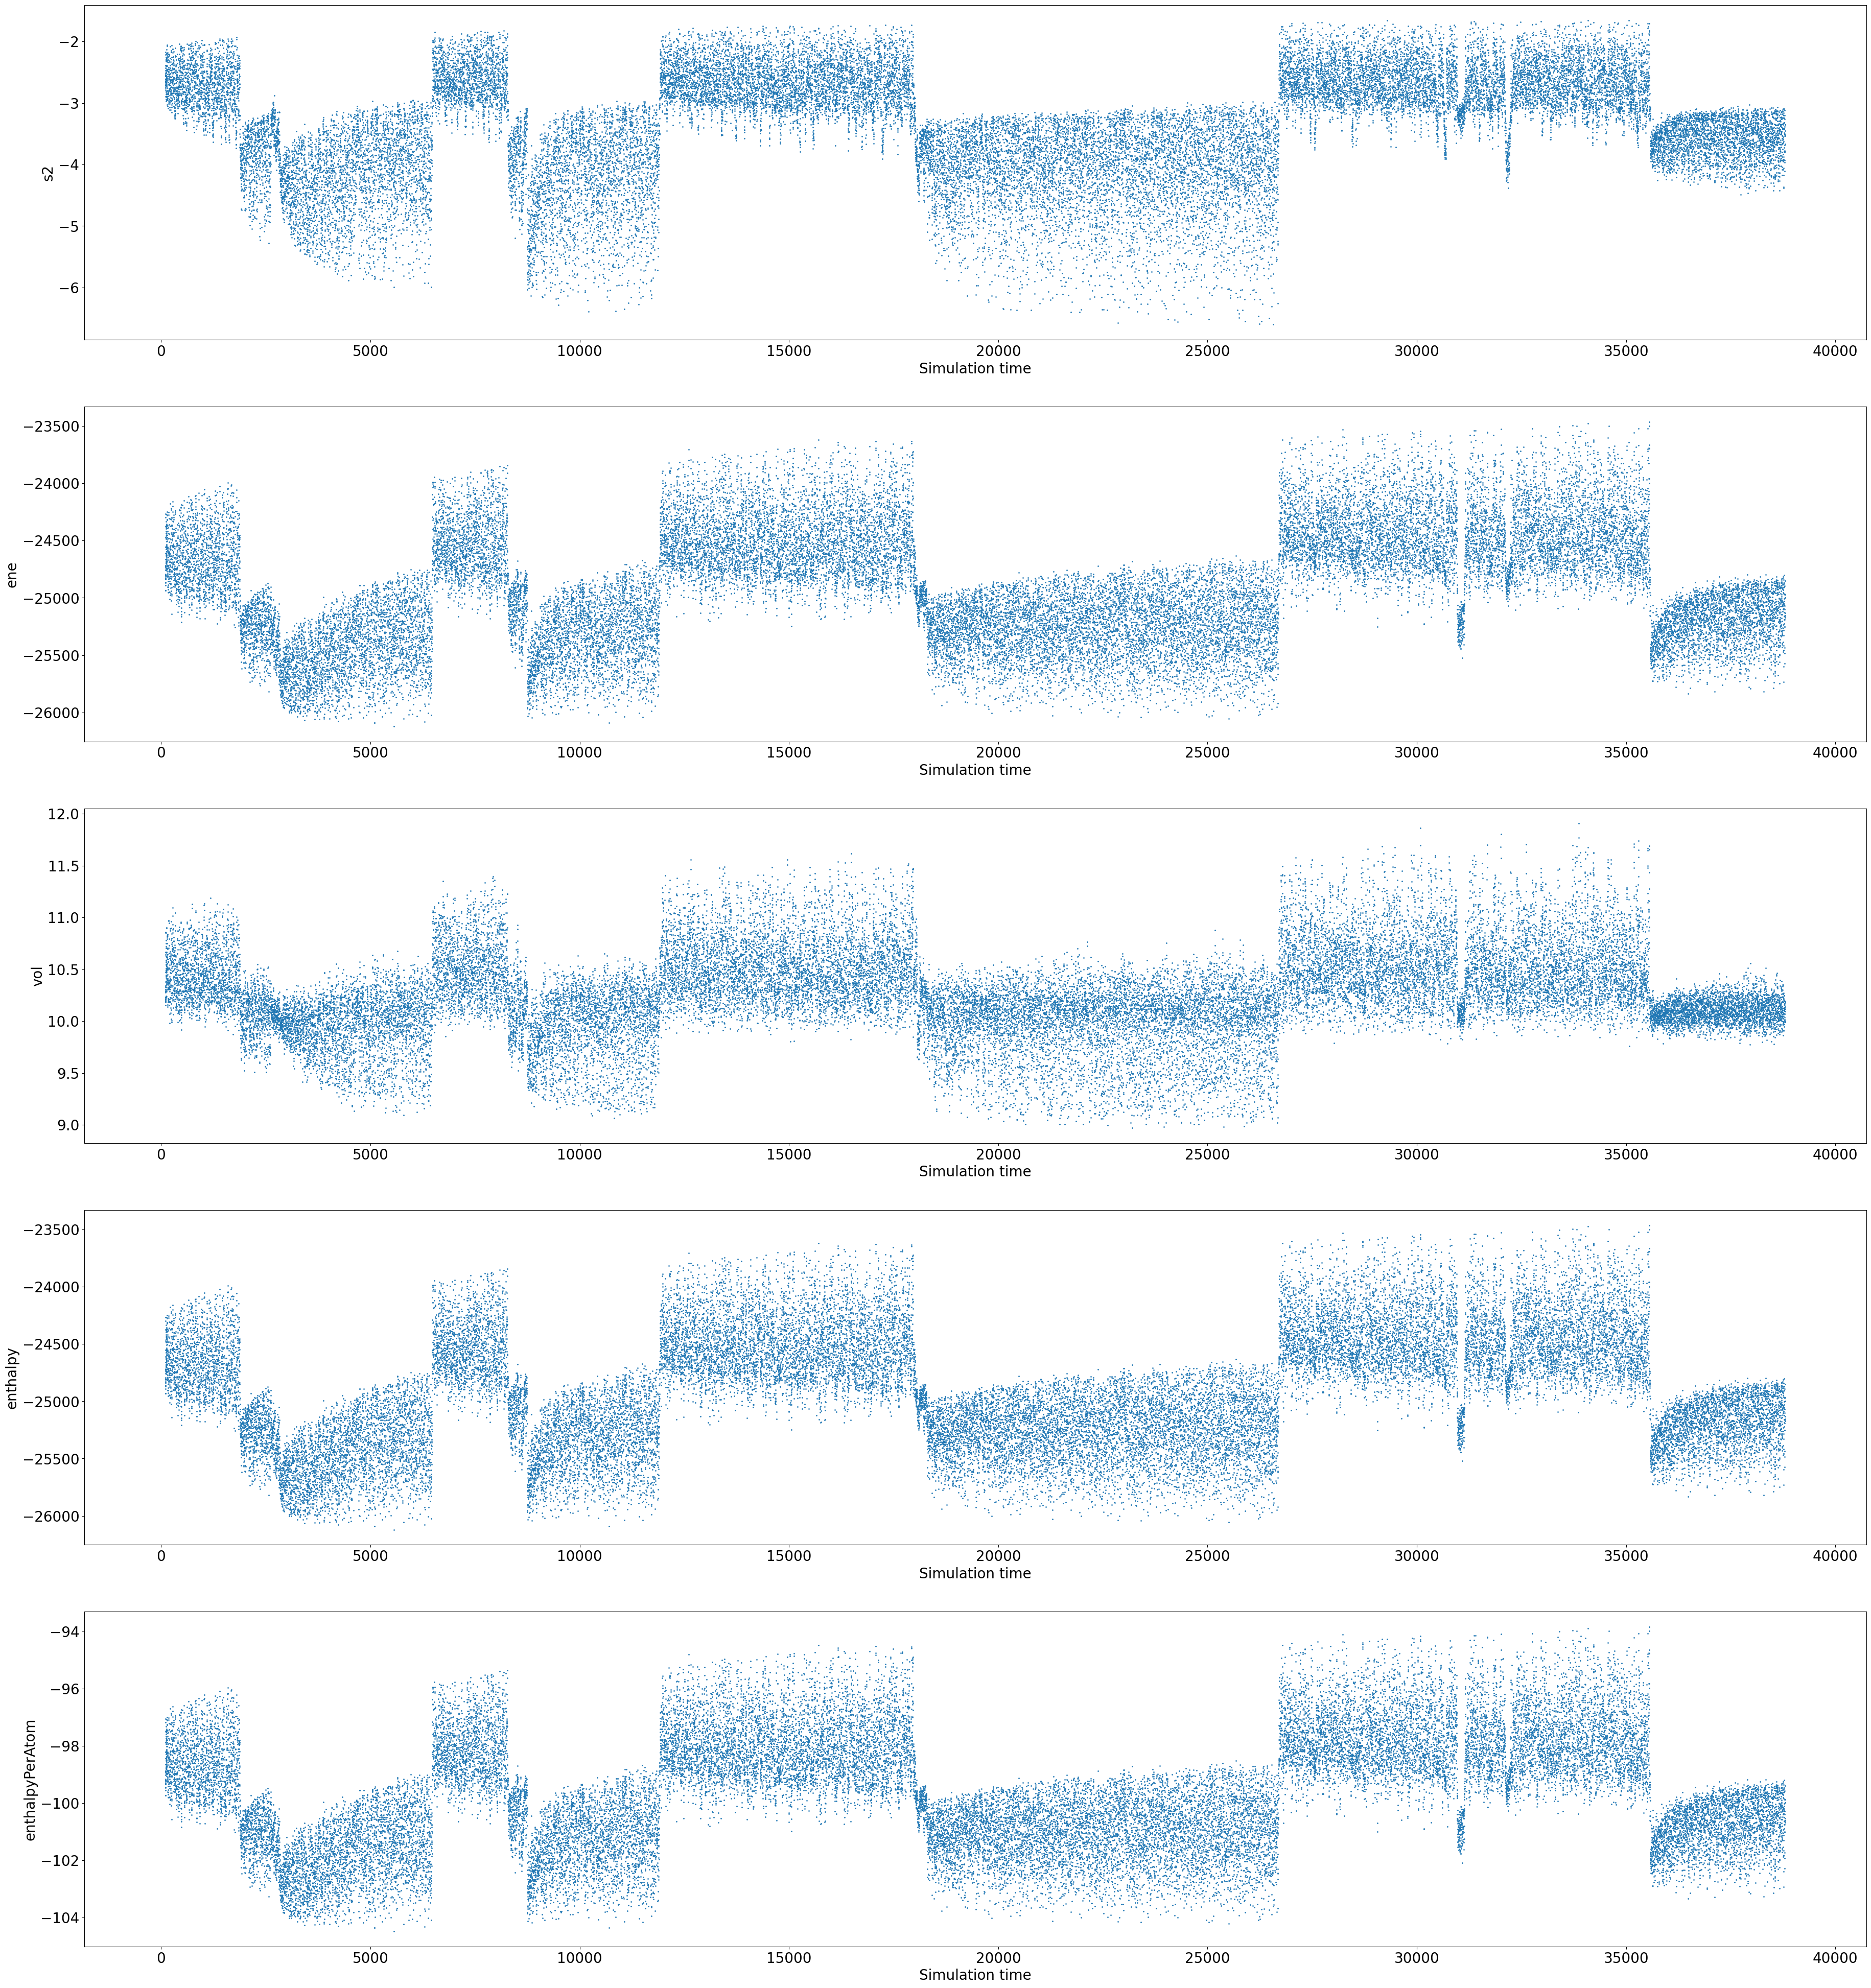

In [17]:
import plumed
from matplotlib import pyplot as plt
from matplotlib import rc

# visualize CV file
data=plumed.read_as_pandas("colvars/COLVAR")

labels = ['s2', 'ene', 'vol', 'enthalpy', 'enthalpyPerAtom'] #, 'metad.bias', 'metad.rbias', 'metad.rct' ]
fontsize = 20
font = {'family': 'sans', 'weight': 'normal', 'size': fontsize}
rc('font', **font)

fig = plt.figure(figsize=(45, 80))
for n,label in enumerate(labels):
    ax = fig.add_subplot(8,1,n+1)
    # plot phi during simulation (first 200k points)
    plt.plot(data["time"][:],data[label][:],'o', ms=1)
    # x-y axis labels
    plt.xlabel("Simulation time")
    plt.ylabel(label)
 

plt.show()

